In [18]:
import pandas as pd
import os

df = pd.DataFrame()
"""
for json_file in os.listdir("dataset/jsonl/"):
    df = pd.concat([df, pd.read_json("dataset/jsonl/" + json_file, lines=True)])
    print(f"Added {json_file} to dataframe.")
"""
df = pd.read_json('dataset/jsonl/en-US.jsonl', lines=True)

In [1]:
%run -i "preprocess_lang.ipynb"
%run -i "preprocess_nolang.ipynb"
%run -i "evaluation.ipynb"

In [20]:
df.head()

id locale partition scenario             intent  \
0   0  en-US      test    alarm          alarm_set   
1   1  en-US     train    alarm          alarm_set   
2   2  en-US     train    alarm          alarm_set   
3   3  en-US      test    audio  audio_volume_mute   
4   4  en-US     train    audio  audio_volume_mute   

                                   utt  \
0      wake me up at five am this week   
1      wake me up at nine am on friday   
2  set an alarm for two hours from now   
3                                quiet   
4                           olly quiet   

                                           annot_utt  worker_id  
0  wake me up at [time : five am] [date : this week]          1  
1  wake me up at [time : nine am] on [date : friday]          1  
2       set an alarm for [time : two hours from now]          1  
3                                              quiet          1  
4                                         olly quiet          1

In [21]:
from toolz.functoolz import pipe

df["locale"] = df["locale"].apply(lambda x: x.split("-")[0])

params = [
    remove_punctuation,
    lowercase,
    tokenize,
    apply_stemming
]


df = pipe(
    df,
    *params
)


df['utt'] = df['utt'].apply(lambda x: " ".join(x))
df, encoder = encode_labels(df)

print(f"Finished preprocessing dataset.\n\n")


Finished preprocessing dataset.




In [22]:
df.head()

id locale partition scenario  intent                                 utt  \
0   0     en      test    alarm       2     wake me up at five am this week   
1   1     en     train    alarm       2     wake me up at nine am on friday   
2   2     en     train    alarm       2  set an alarm for two hour from now   
3   3     en      test    audio       4                               quiet   
4   4     en     train    audio       4                          olli quiet   

                                           annot_utt  worker_id  \
0  wake me up at [time : five am] [date : this week]          1   
1  wake me up at [time : nine am] on [date : friday]          1   
2       set an alarm for [time : two hours from now]          1   
3                                              quiet          1   
4                                         olly quiet          1   

                                            utt_text  
0  (w, a, k, e,  , m, e,  , u, p,  , a, t,  , f, ...  
1  (w, a, k, e,  , m, e,  , u, p,  , a, t,  , n, ...  
2  (s, e, t,  , a, n,  , a, l, a, r, m,  , f, o, ...  
3                                    (q, u, i, e, t)  
4                     (o, l, l, y,  , q, u, i, e, t)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer()
vectorized = vectorizer.fit_transform(df['utt'].to_list())


In [24]:
input_cols = [f'__{feature_name}' for feature_name in vectorizer.get_feature_names_out()]
output_cols = ['intent']
averages = [None, "macro", "weighted", "micro", "samples"]

In [25]:
count_vect_df = pd.DataFrame(vectorized.todense(), columns=input_cols)
df = pd.concat([df, count_vect_df], axis=1)

In [26]:
training_df = df[df['partition'] != 'test']
testing_df = df[df['partition'] == 'test']

In [27]:
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

In [28]:
training_inputs = vectorizer.transform(training_df['utt'].values)
testing_inputs = vectorizer.transform(testing_df['utt'].values)
training_classes = training_df[output_cols].values.reshape(-1)
testing_classes = testing_df[output_cols].values.reshape(-1)

In [29]:
english_indices = testing_df.index[(testing_df['locale'] == 'en')].values

indices = {
    'en': english_indices,
}

C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params for MultinomialNB: {'model__alpha': 0.5}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.6997935402618228
Classification report
              precision    recall  f1-score   support

           0     0.8333    0.7353    0.7812        34
           1     0.9333    0.6667    0.7778        21
           2     0.8095    0.8293    0.8193        41
           3     1.0000    0.5455    0.7059        11
           4     0.9474    0.5625    0.7059        32
           5     1.0000    0.0000    0.0000         6
           6     0.4706    0.6154    0.5333        13
           7     0.6250    0.7937    0.6993       126
           8     0.8630    0.9403    0.9000        67
           9     0.7539    0.9234    0.8301       209
          11     0.9365    0.8194    0.8741        72
          12     1.0000    0.3333    0.5000        15
          13     0.7353    0.8523    0.7895        88
          14     0.8000    0.3333    0.4706        12
          

C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


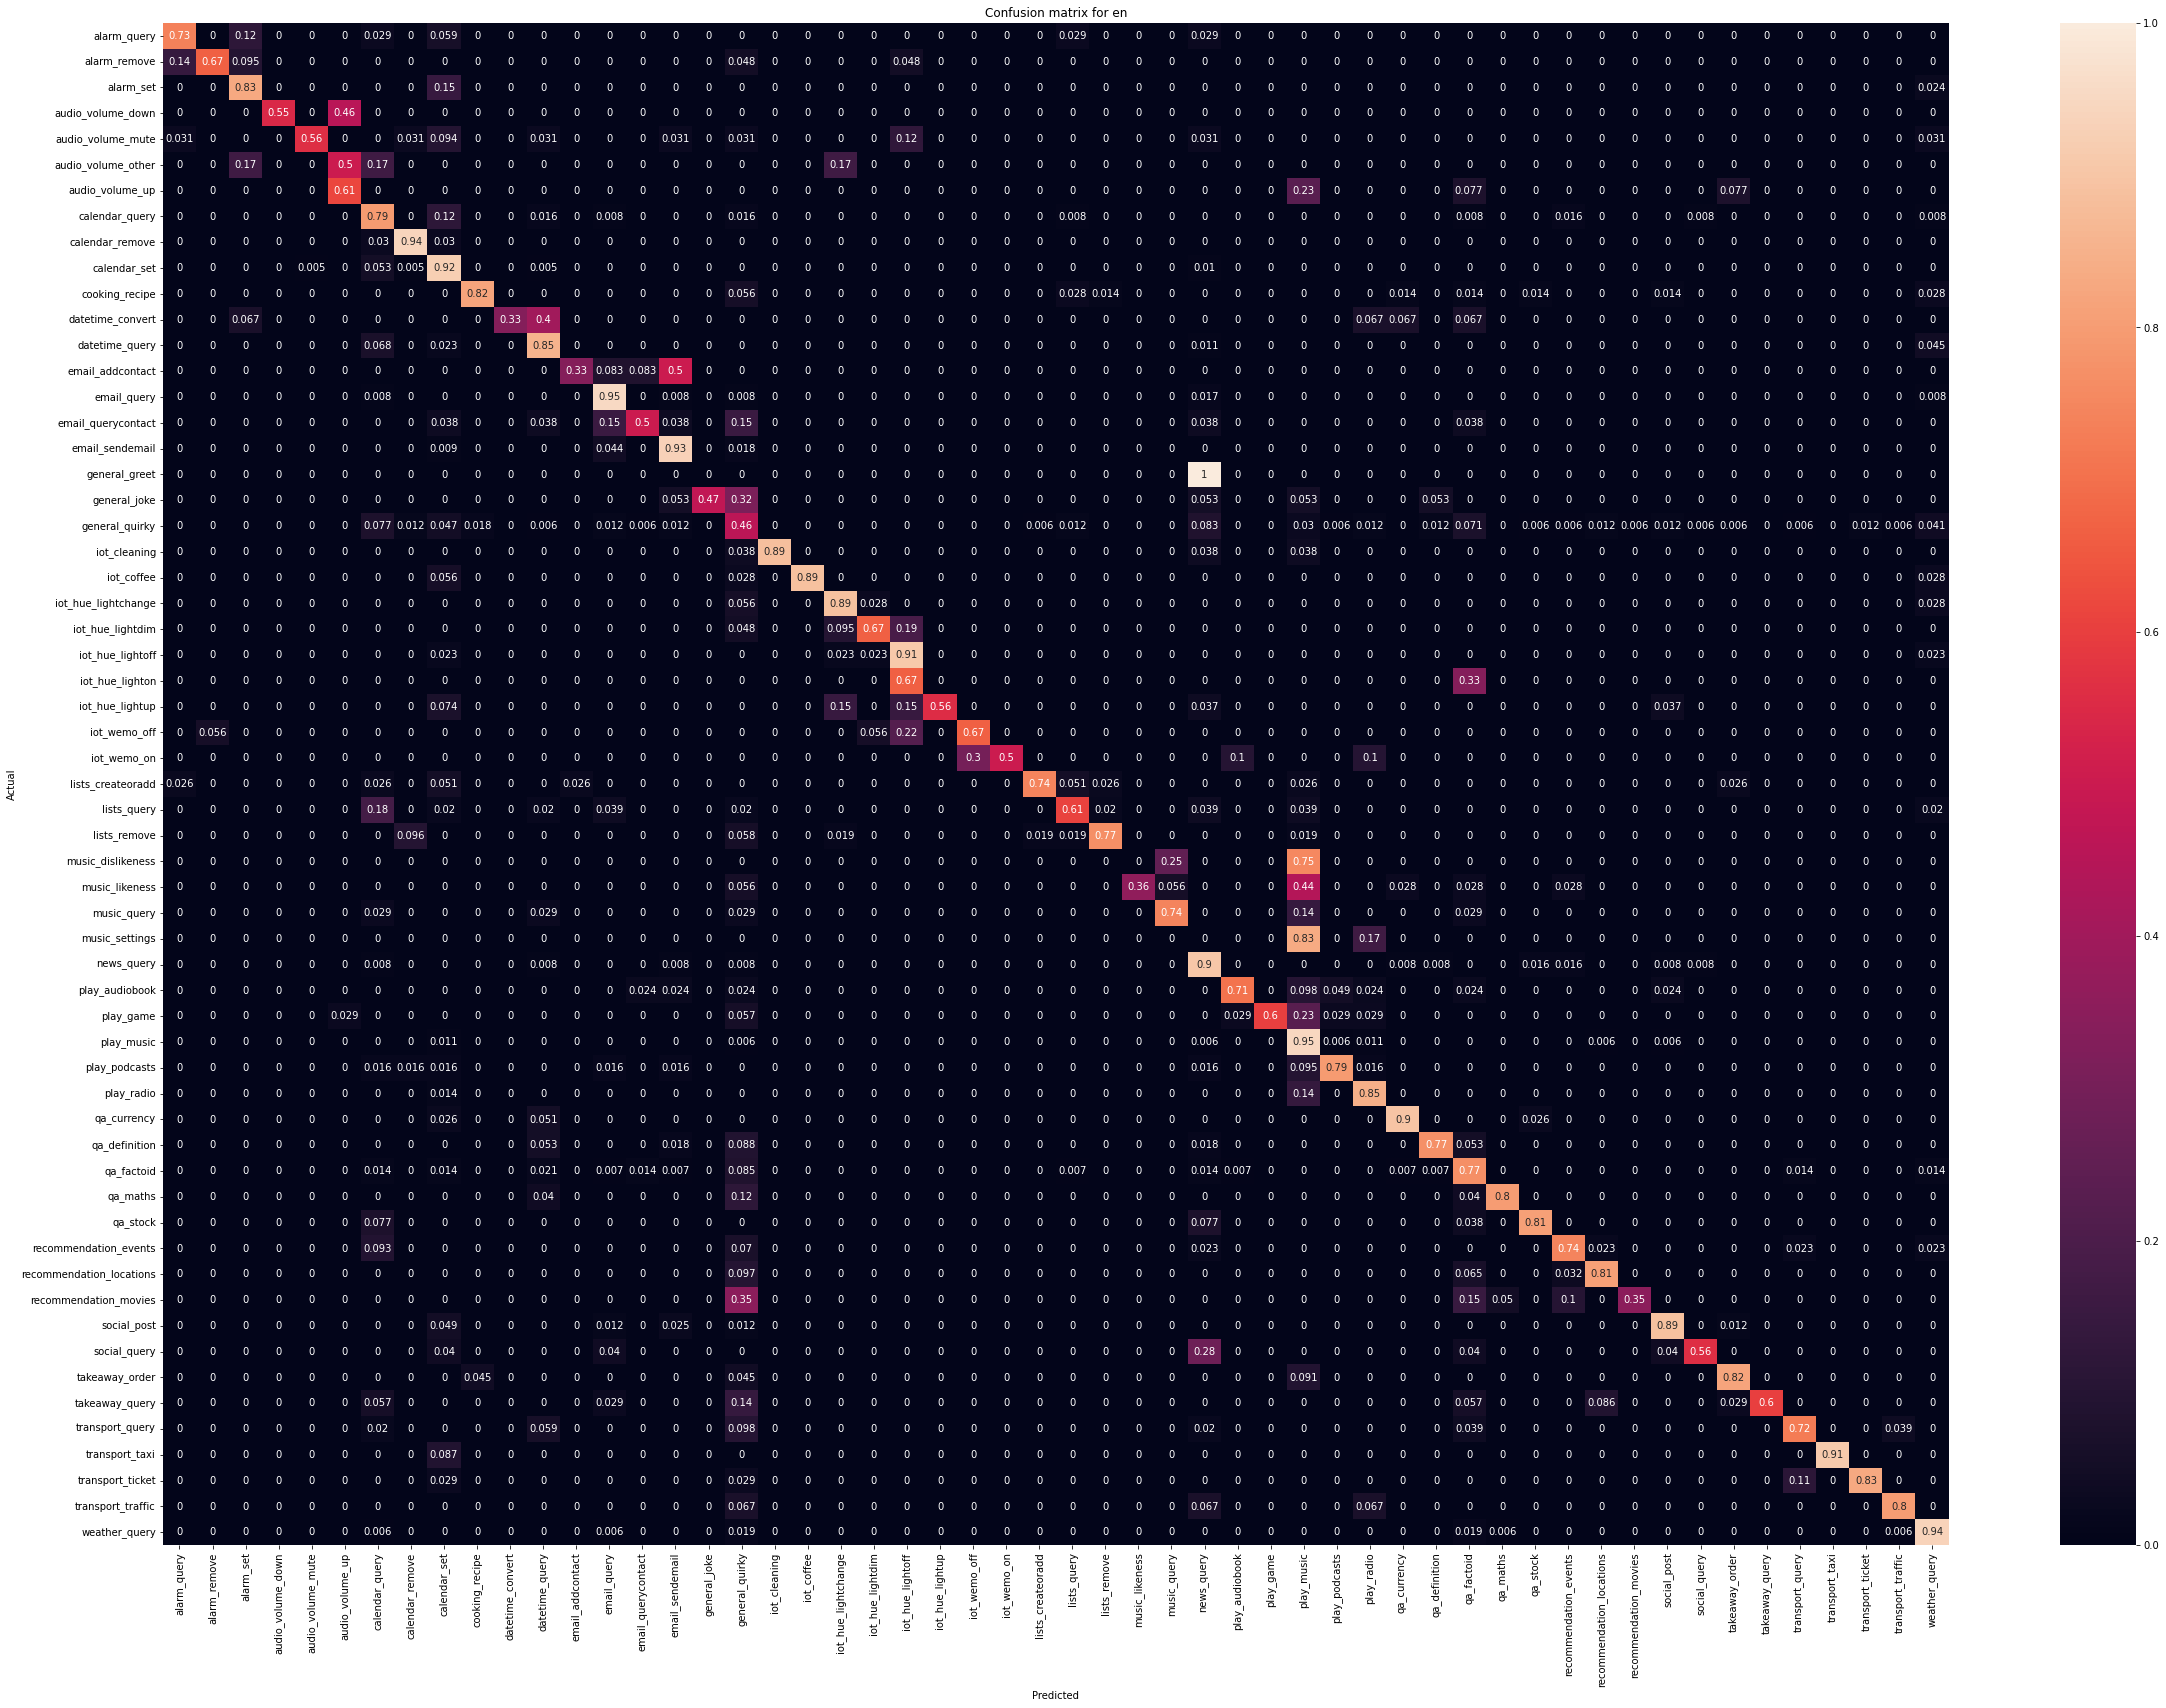

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = train_and_use_model(
    MultinomialNB(),
    {
        "model__alpha": [0.1, 0.5, 1.0, 1.5, 2.0],
    },
    n_iter=1,
    indices=indices,
    encoder=encoder,
)

# MultinomialNB

Best params:
{
    'model__alpha': 0.1
}

In [ ]:
#import xgboost as xgb
import xgboost as xgb

xgboost = train_and_use_model(
    xgb.XGBClassifier(),
    {
        "model__n_estimators": [100, 200, 300, 400, 500],
        "model__max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
        "model__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "model__booster": ["gbtree", "gblinear", "dart"],
        "model__gamma": [0, 0.25, 0.5, 1.0],
        "model__min_child_weight": [1, 3, 5, 7],
        "model__max_delta_step": [0, 0.2, 0.6, 1.0],
        "model__subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    },
    n_iter=3
)

C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\

[04:44:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "subsample" } are not used.

Best params for XGBClassifier: {'model__subsample': 0.7, 'model__n_estimators': 200, 'model__min_child_weight': 3, 'model__max_depth': 3, 'model__max_delta_step': 1.0, 'model__learning_rate': 0.05, 'model__gamma': 0.5, 'model__booster': 'gblinear'}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.7887292811188353
Classification report
              precision    recall  f1-score   support

           0     0.9032    0.8235    0.8615        34
           1     0.9474    0.8571    0.9000        21
           2     0.7907    0.8293    0.8095        41
           3     0.8182    0.8182    0.8182        11
           4     0.8333    0.9375    0.8824        32
           5     1.0000    0.3333    0.50

# XGBoost

Best Params:
{
    'model__subsample': 0.7,
    'model__n_estimators': 200, 
    'model__min_child_weight': 3, 
    'model__max_depth': 3, 
    'model__max_delta_step': 1.0, 
    'model__learning_rate': 0.05, 
    'model__gamma': 0.5, 
    'model__booster': 'gblinear'
}

In [30]:
#import sgd classifier
from sklearn.linear_model import SGDClassifier

sgd = train_and_use_model(
    SGDClassifier,
    {
        "model__loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
        "model__penalty": ["l2", "l1", "elasticnet"],
        "model__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0],
        "model__l1_ratio": [0.15, 0.3, 0.45, 0.6, 0.75, 0.9],
    },
    n_iter=1
)

# Logistic Regression

Best Params:
{
    'model__penalty': 0.7,
    'model__solver': 200, 
    'model__C': 3, 
    'model__max_iter': 3, 
    'model__class_weight': 1.0
}

In [1]:
import os
import pandas as pd

df = pd.DataFrame()

for json_file in os.listdir("dataset/jsonl/"):
    df = pd.concat([df, pd.read_json("dataset/jsonl/" + json_file, lines=True)], ignore_index=True)
    print(f"Added {json_file} to dataframe.")

df["locale"] = df["locale"].apply(lambda x: x.split("-")[0])

Added af-ZA.jsonl to dataframe.
Added am-ET.jsonl to dataframe.
Added ar-SA.jsonl to dataframe.
Added az-AZ.jsonl to dataframe.
Added bn-BD.jsonl to dataframe.
Added cy-GB.jsonl to dataframe.
Added da-DK.jsonl to dataframe.
Added de-DE.jsonl to dataframe.
Added el-GR.jsonl to dataframe.
Added en-US.jsonl to dataframe.
Added es-ES.jsonl to dataframe.
Added fa-IR.jsonl to dataframe.
Added fi-FI.jsonl to dataframe.
Added fr-FR.jsonl to dataframe.
Added he-IL.jsonl to dataframe.
Added hi-IN.jsonl to dataframe.
Added hu-HU.jsonl to dataframe.
Added hy-AM.jsonl to dataframe.
Added id-ID.jsonl to dataframe.
Added is-IS.jsonl to dataframe.
Added it-IT.jsonl to dataframe.
Added ja-JP.jsonl to dataframe.
Added jv-ID.jsonl to dataframe.
Added ka-GE.jsonl to dataframe.
Added km-KH.jsonl to dataframe.
Added kn-IN.jsonl to dataframe.
Added ko-KR.jsonl to dataframe.
Added lv-LV.jsonl to dataframe.
Added ml-IN.jsonl to dataframe.
Added mn-MN.jsonl to dataframe.
Added ms-MY.jsonl to dataframe.
Added my

In [8]:
df[df["locale"]=="en"].head(-1)

id locale partition scenario              intent  \
148689      0     en      test    alarm           alarm_set   
148690      1     en     train    alarm           alarm_set   
148691      2     en     train    alarm           alarm_set   
148692      3     en      test    audio   audio_volume_mute   
148693      4     en     train    audio   audio_volume_mute   
...       ...    ...       ...      ...                 ...   
165204  17175     en     train    email  email_querycontact   
165205  17176     en     train    email         email_query   
165206  17177     en     train    email         email_query   
165207  17178     en     train    email         email_query   
165208  17179     en      test    email         email_query   

                                        utt  \
148689      wake me up at five am this week   
148690      wake me up at nine am on friday   
148691  set an alarm for two hours from now   
148692                                quiet   
148693                           olly quiet   
...                                     ...   
165204          send hi in watsapp to vikki   
165205                     do i have emails   
165206                  what emails are new   
165207       do i have new emails from john   
165208            has john sent me an email   

                                                annot_utt  worker_id  \
148689  wake me up at [time : five am] [date : this week]          1   
148690  wake me up at [time : nine am] on [date : friday]          1   
148691       set an alarm for [time : two hours from now]          1   
148692                                              quiet          1   
148693                                         olly quiet          1   
...                                                   ...        ...   
165204                        send hi in watsapp to vikki         11   
165205                                   do i have emails         12   
165206                                what emails are new         12   
165207          do i have new emails from [person : john]         12   
165208               has [person : john] sent me an email         12   

       slot_method judgments  
148689         NaN       NaN  
148690         NaN       NaN  
148691         NaN       NaN  
148692         NaN       NaN  
148693         NaN       NaN  
...            ...       ...  
165204         NaN       NaN  
165205         NaN       NaN  
165206         NaN       NaN  
165207         NaN       NaN  
165208         NaN       NaN  

[16520 rows x 10 columns]

In [4]:
from toolz.functoolz import pipe

params = [
    remove_punctuation,
    lowercase,
    tokenize,
    apply_stemming,
]

df = pipe(
    df,
    *params
)

df, encoder = encode_labels(df)

df['utt'] = df['utt'].apply(lambda x: " ".join(x))

print(f"Finished preprocessing dataset.\n\n")



Finished preprocessing dataset.




In [14]:
#import tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(df[df['partition'] != 'test']['utt'].values)

CountVectorizer()

In [15]:
input_cols = [f'__{feature_name}' for feature_name in vectorizer.get_feature_names_out()]
output_cols = ['intent']
averages = [None, "macro", "weighted", "micro", "samples"]

In [16]:
training_df = df[df['partition'] != 'test']
testing_df = df[df['partition'] == 'test']

In [17]:
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

In [18]:
training_inputs = vectorizer.transform(training_df['utt'].values)
testing_inputs = vectorizer.transform(testing_df['utt'].values)
training_classes = training_df[output_cols].values.reshape(-1)
testing_classes = testing_df[output_cols].values.reshape(-1)

In [19]:
indices = {}

for lang in testing_df['locale'].unique():
    indices[lang] = testing_df.index[(testing_df['locale'] == lang)].values

In [20]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=0.5)

nb.fit(training_inputs, training_classes)


MultinomialNB(alpha=0.5)

Evaluation metrics for MultinomialNB
MultinomialNB's default score metric: 0.7390851431359363
Classification report
              precision    recall  f1-score   support

           0     0.9194    0.6776    0.7802      1734
           1     0.9643    0.5042    0.6622      1071
           2     0.7076    0.7523    0.7293      2091
           3     0.9367    0.5009    0.6527       561
           4     0.9011    0.5306    0.6680      1632
           5     1.0000    0.0196    0.0385       306
           6     0.4329    0.5400    0.4805       663
           7     0.5449    0.7021    0.6136      6426
           8     0.7946    0.8288    0.8113      3417
           9     0.6102    0.9094    0.7303     10659
          11     0.9150    0.7064    0.7973      3672
          12     0.9633    0.3085    0.4673       765
          13     0.7866    0.8253    0.8055      4488
          14     0.7010    0.2337    0.3505       612
          15     0.7922    0.9090    0.8466      6069
          16     0.

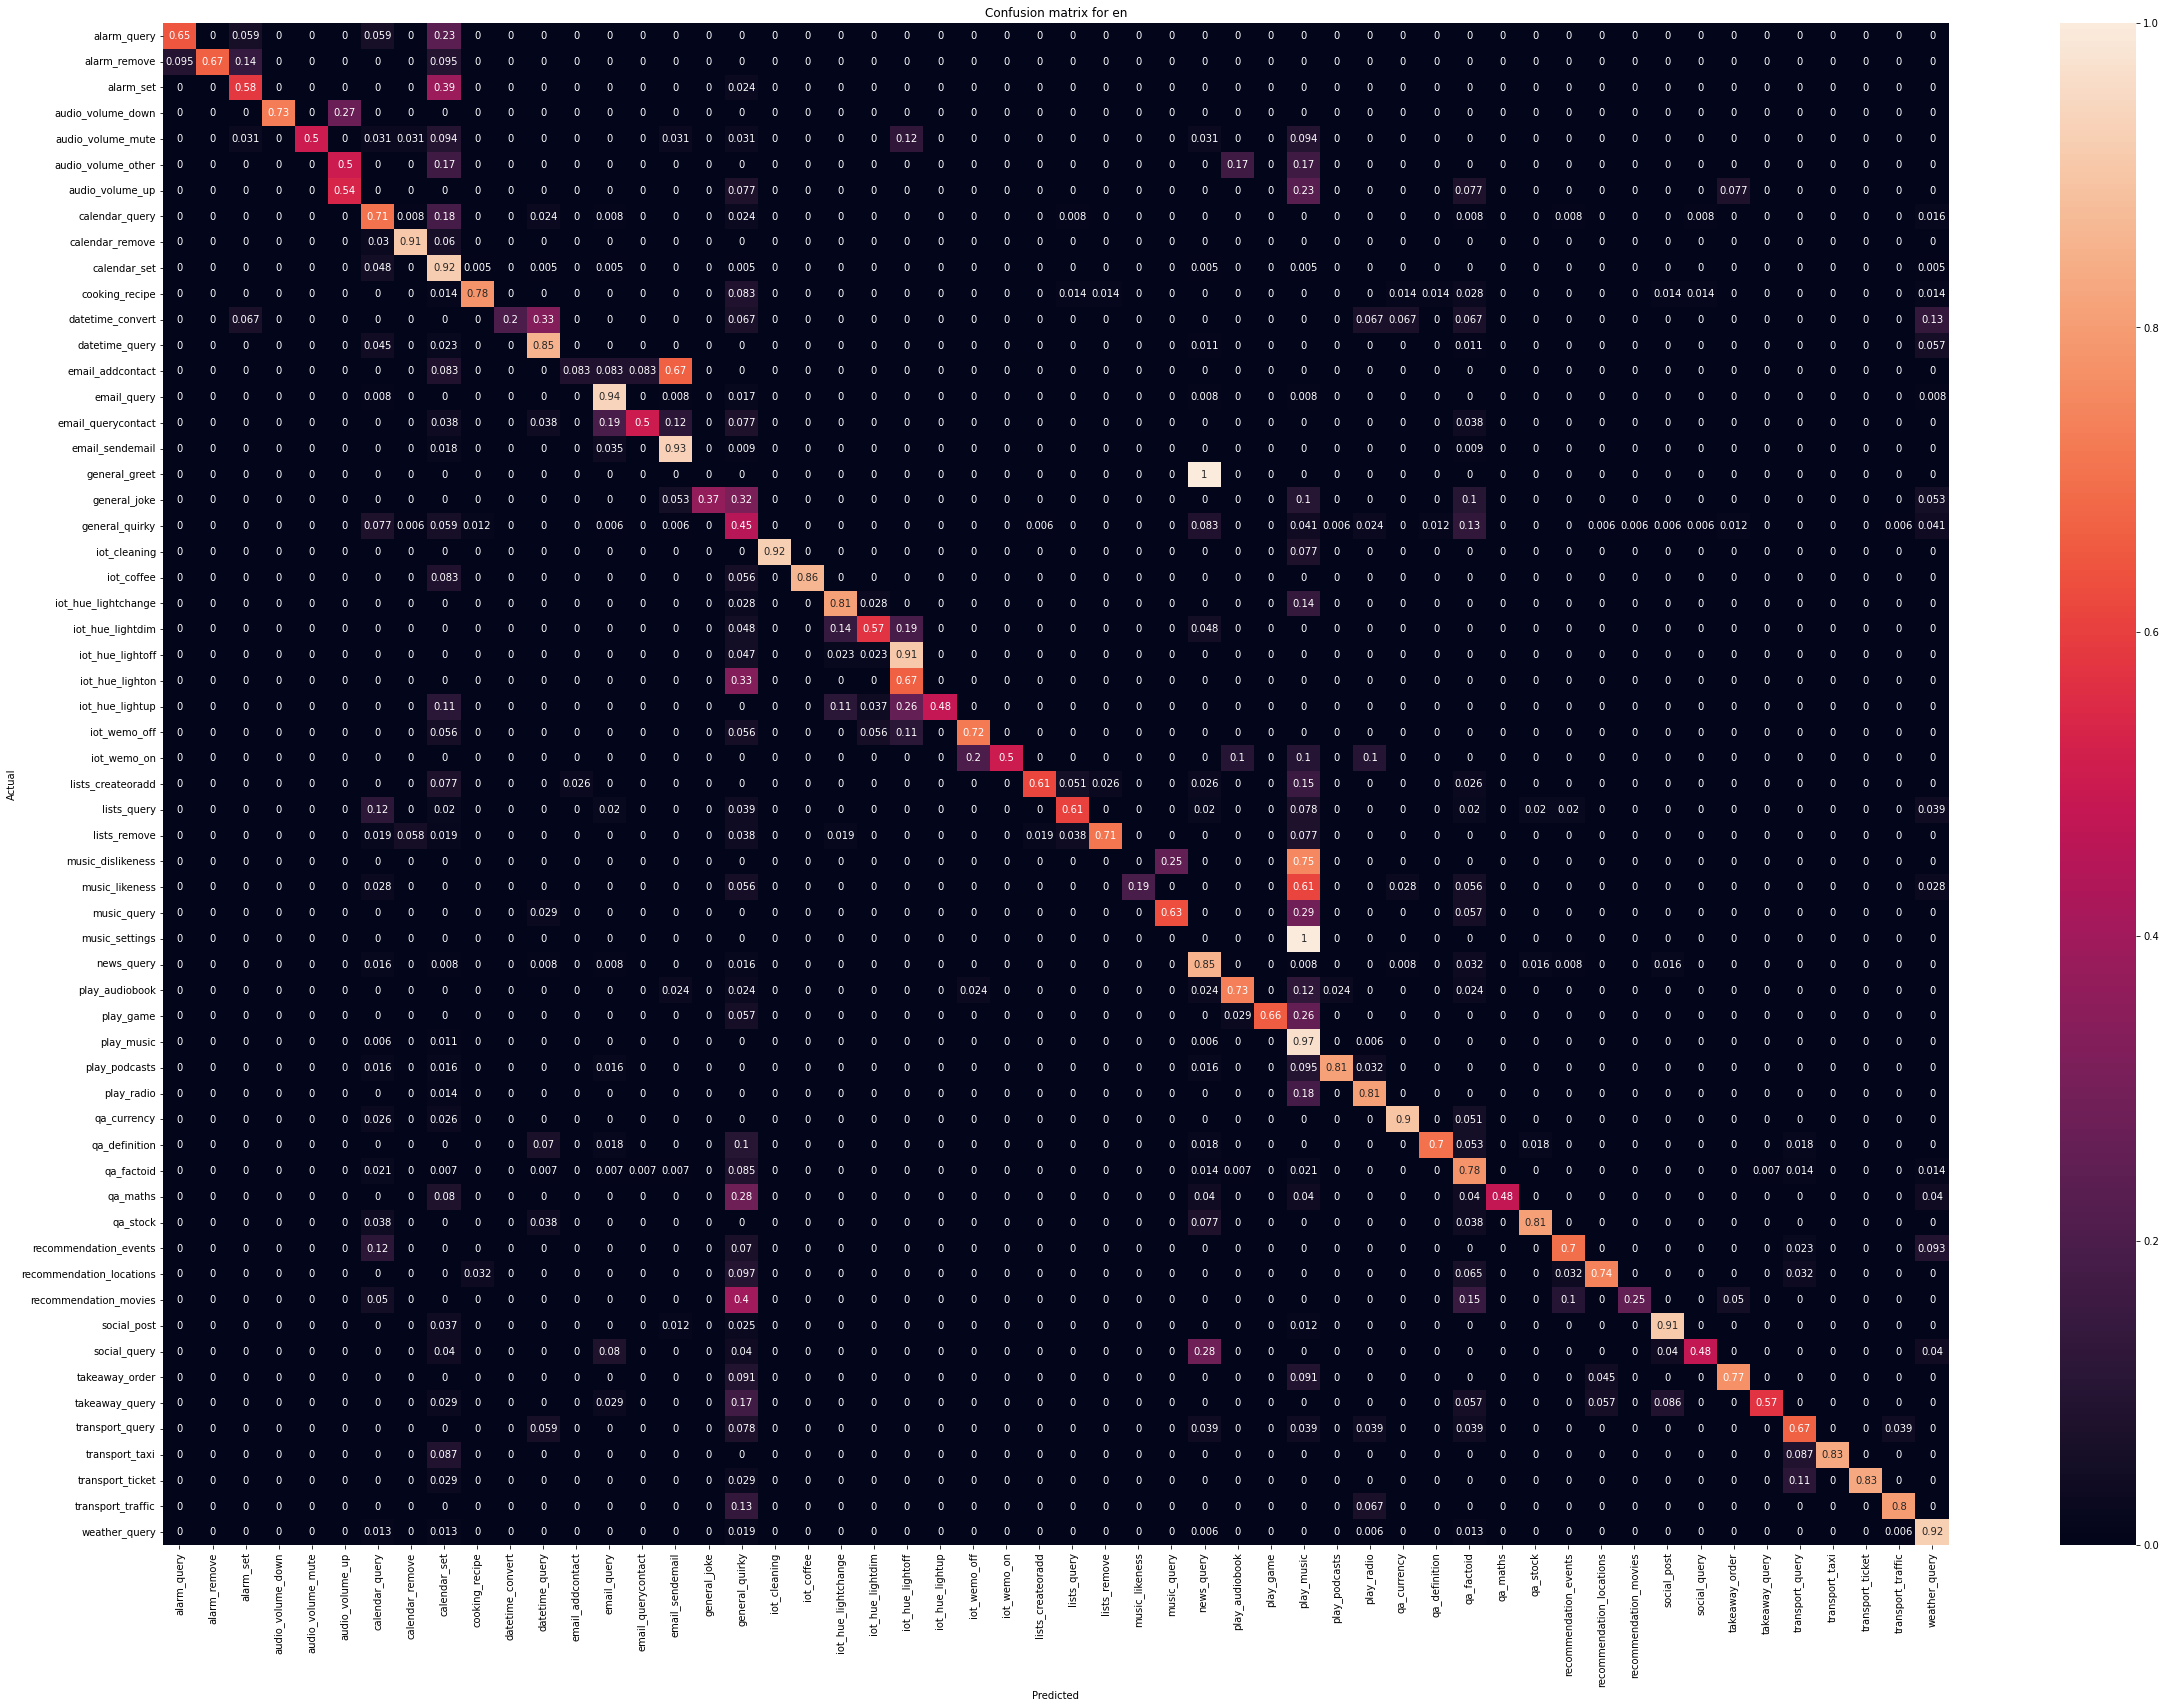

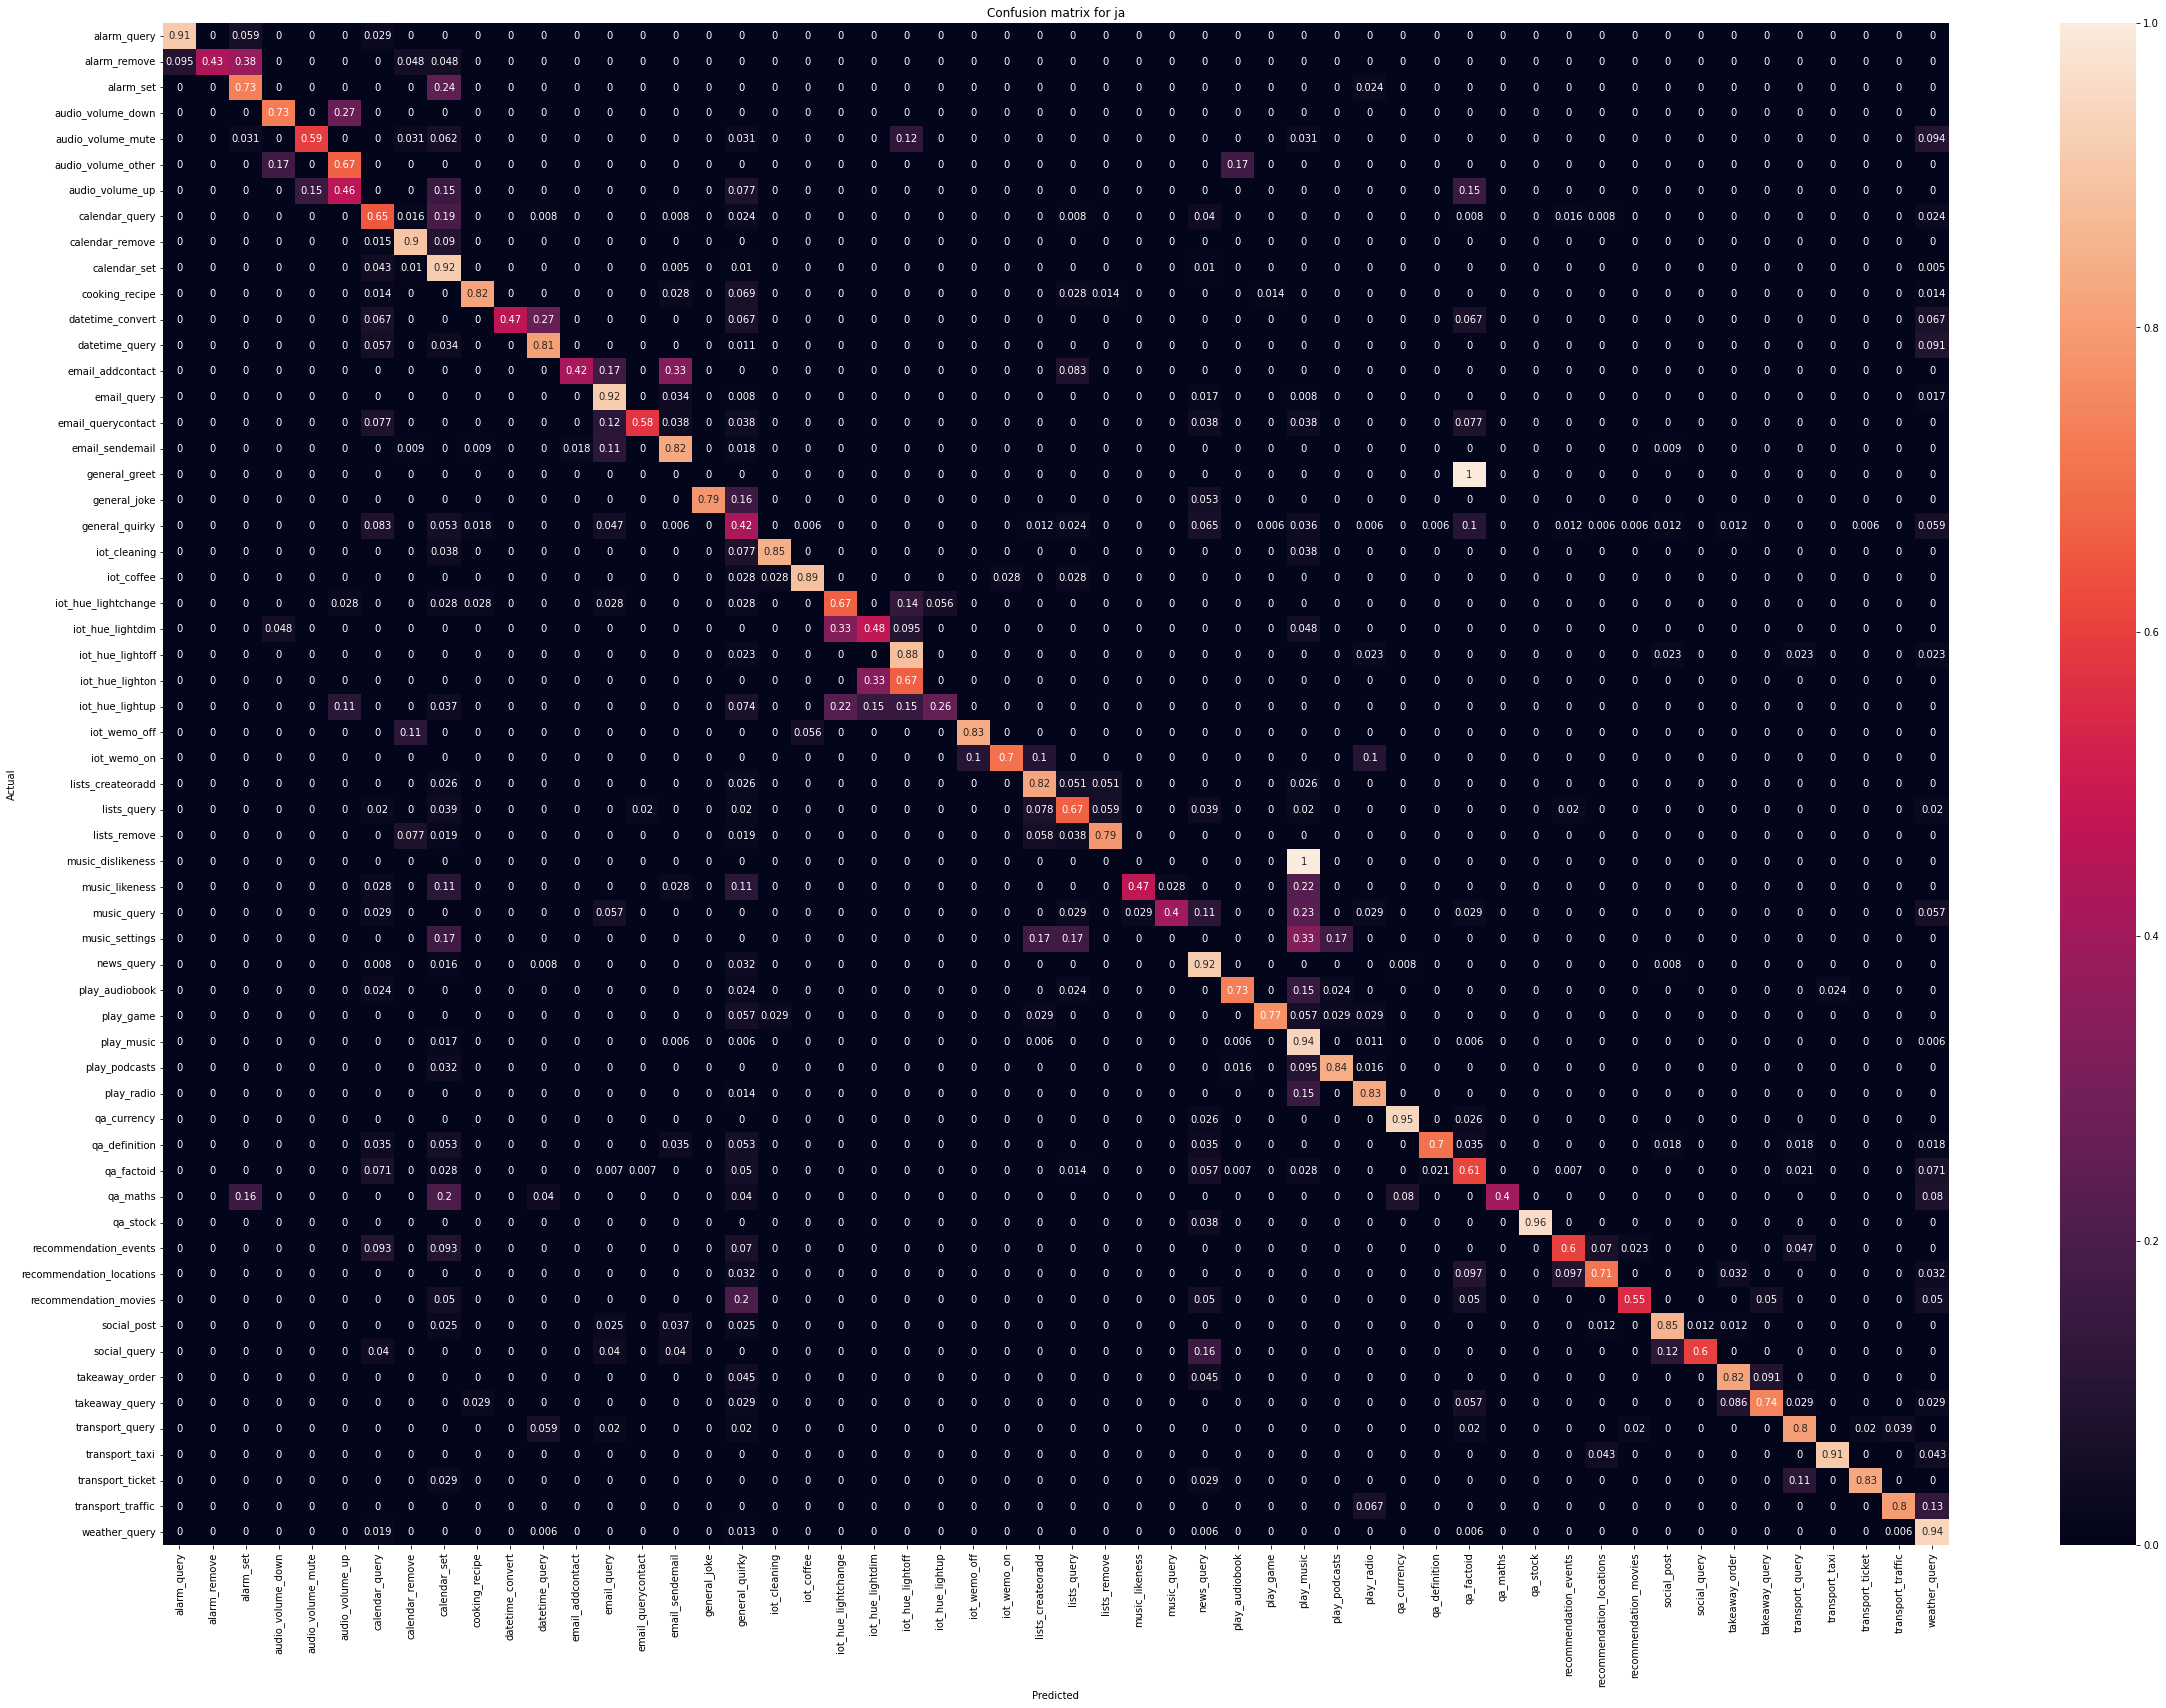

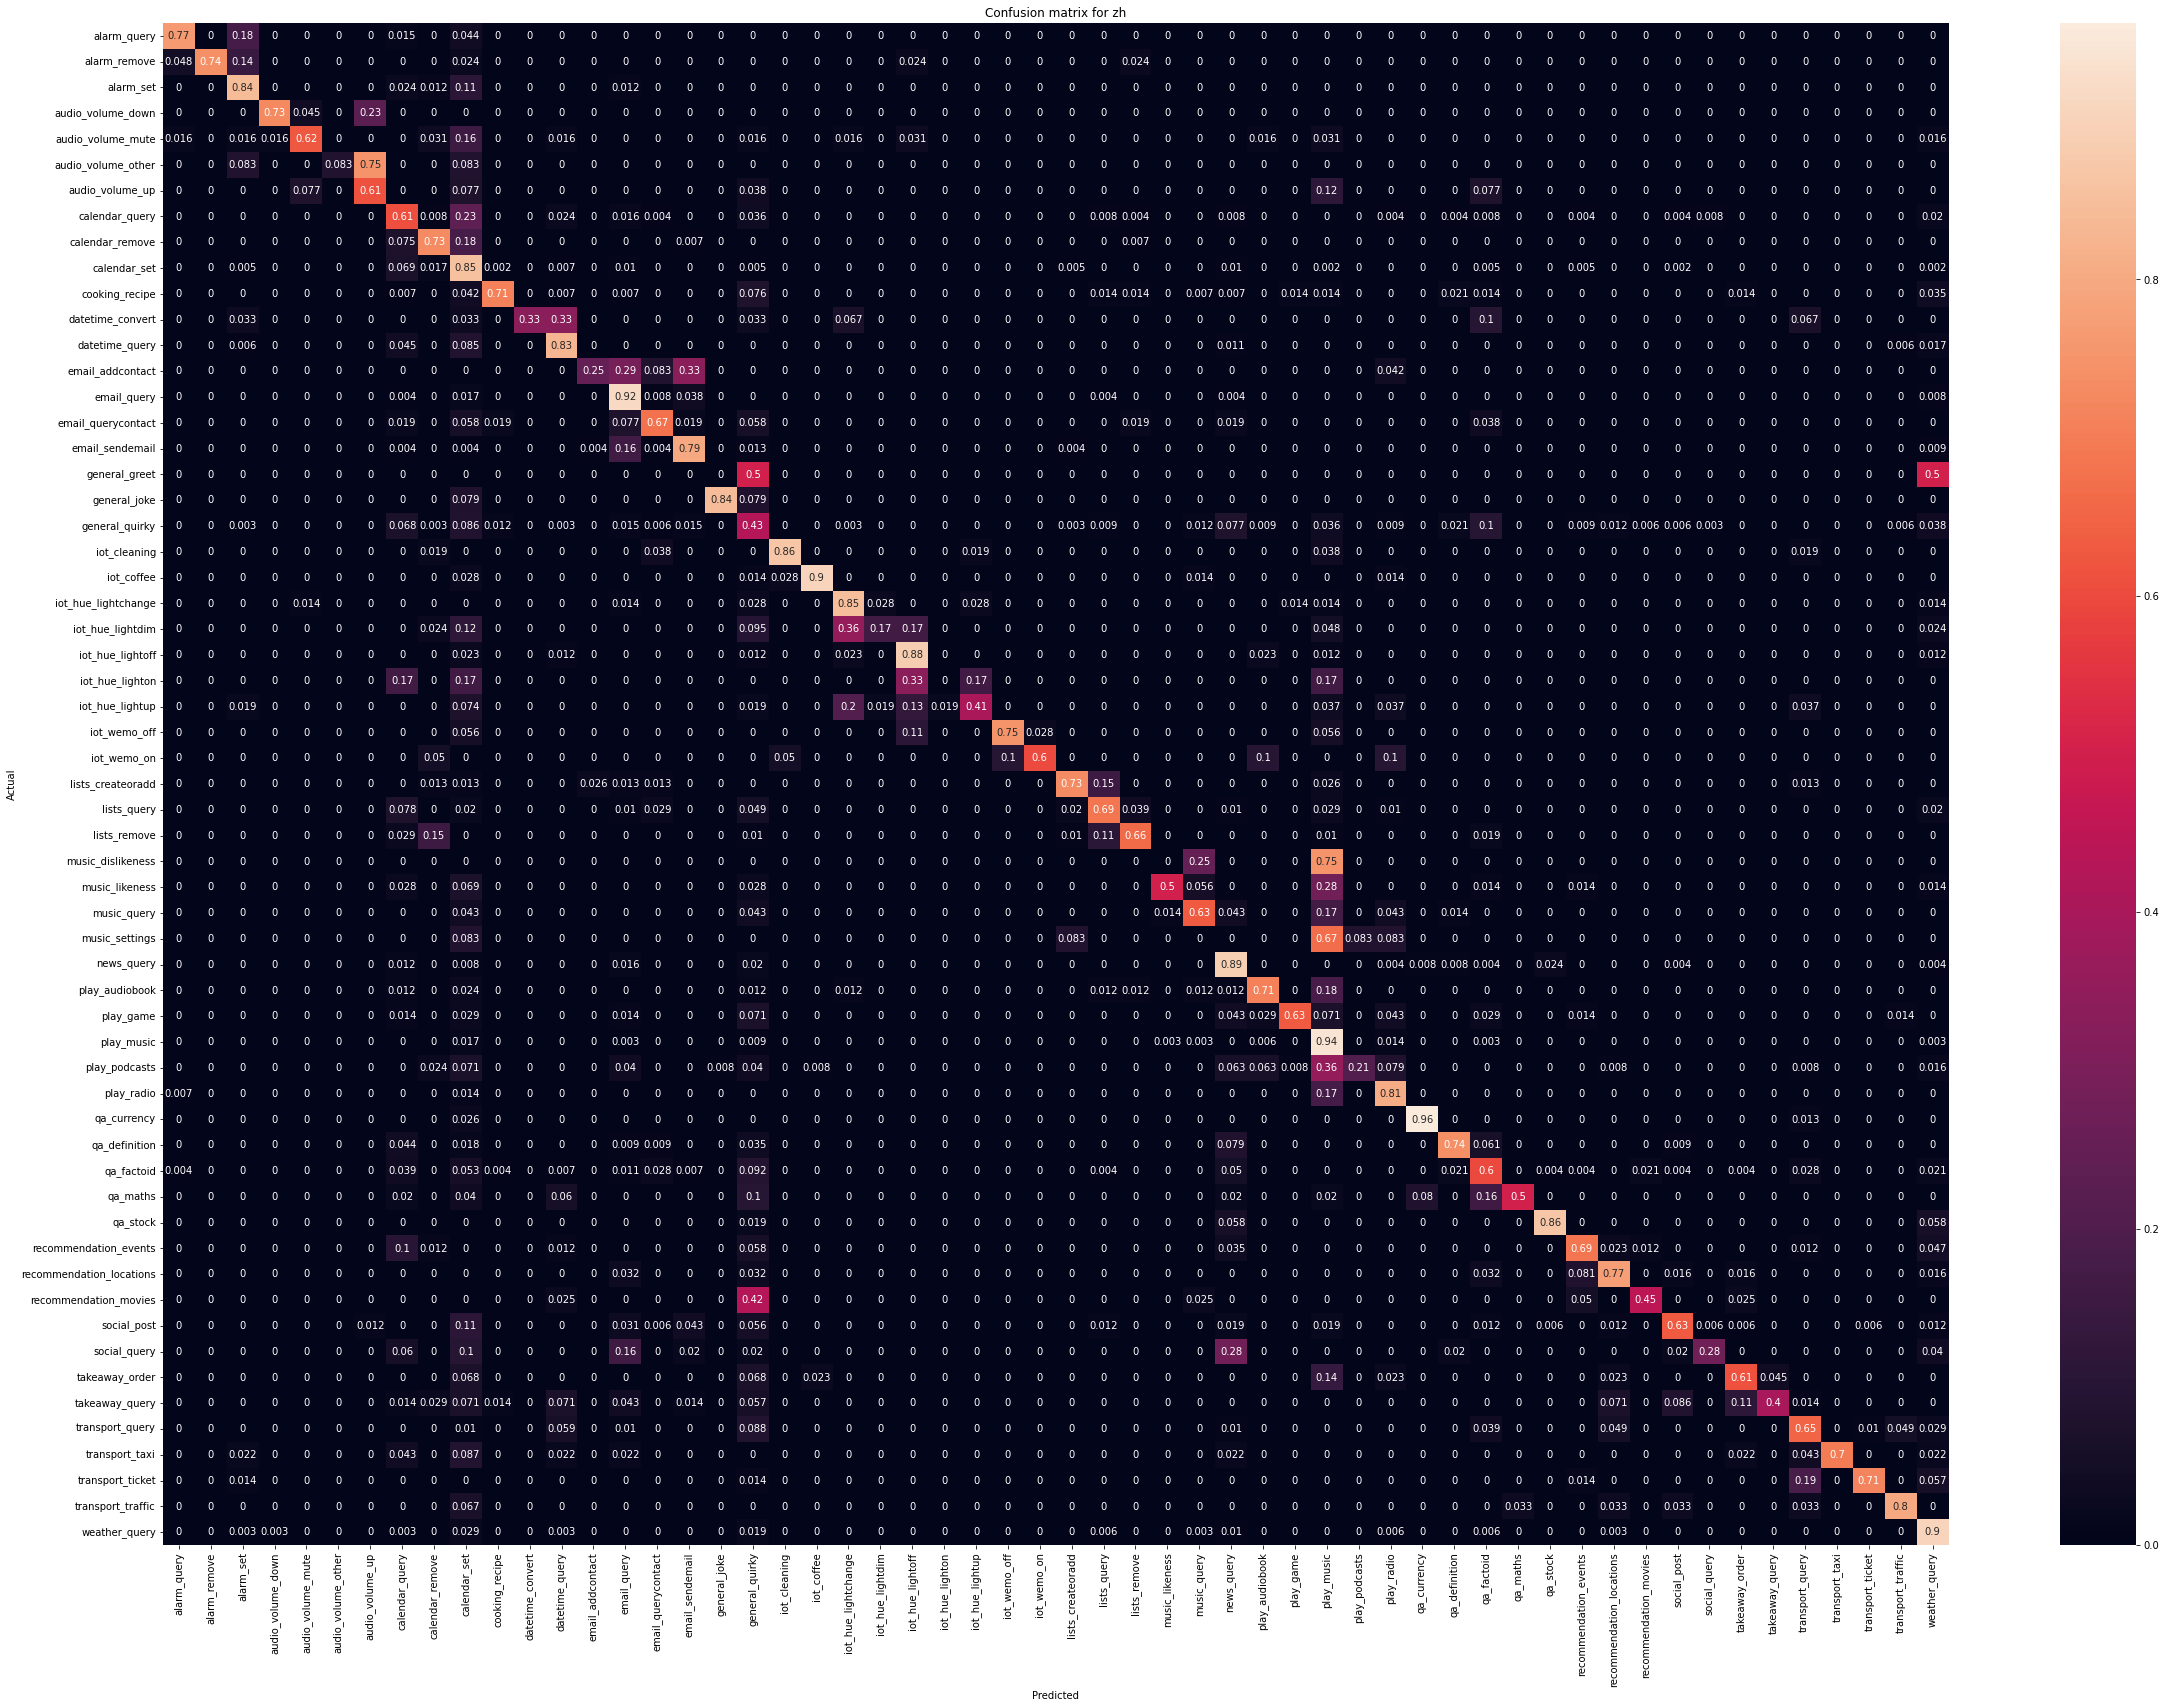

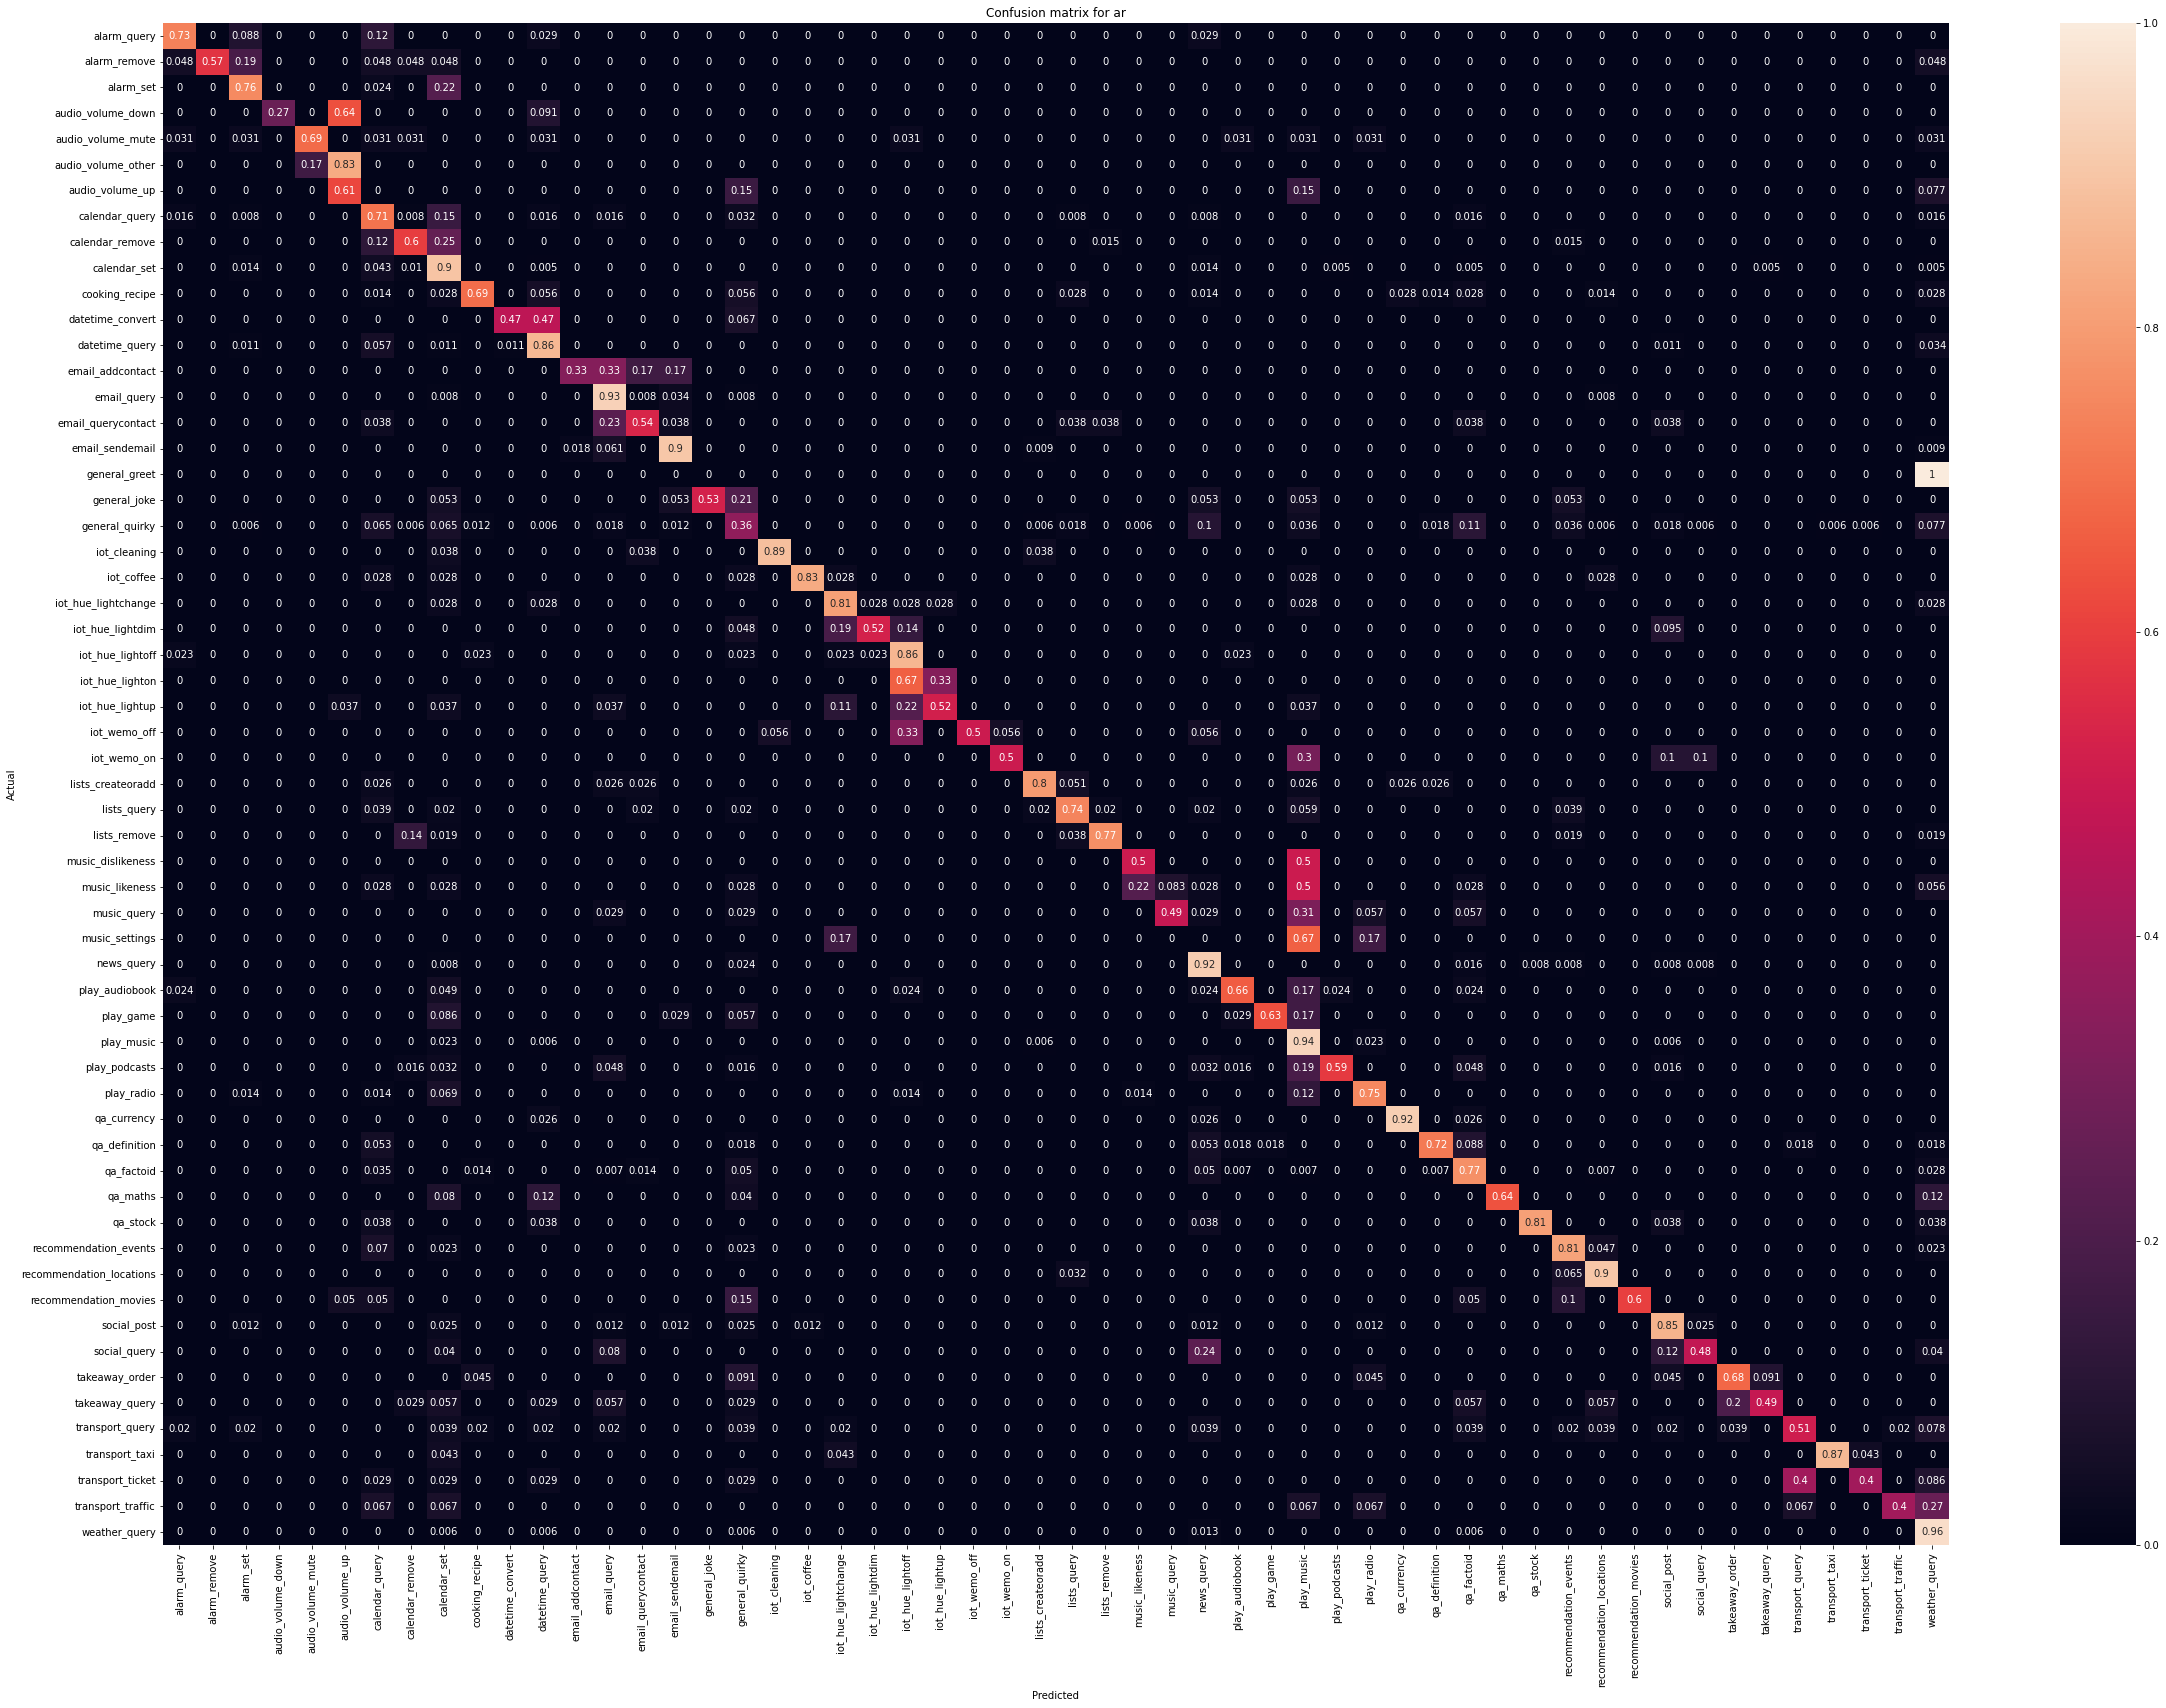

In [21]:
evaluate_model(nb, testing_inputs, testing_classes, encoder, indices)


In [14]:
from xgboost import XGBClassifier

xgboost = XGBClassifier(subsample=0.7, n_estimators=200, min_child_weight=3, max_depth=3, max_delta_step=1, learning_rate=0.05, gamma=0.5, booster='gblinear')

xgboost.fit(training_inputs, training_classes)

[00:56:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "subsample" } are not used.



XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=3, max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

Evaluation metrics for XGBClassifier
XGBClassifier's default score metric: 0.7517900233395308
Classification report
              precision    recall  f1-score   support

           0     0.8403    0.7860    0.8123      1734
           1     0.8252    0.7582    0.7903      1071
           2     0.7095    0.8245    0.7627      2091
           3     0.7661    0.8467    0.8044       561
           4     0.7741    0.7917    0.7828      1632
           5     0.7372    0.3758    0.4978       306
           6     0.5762    0.7240    0.6417       663
           7     0.5708    0.6755    0.6188      6426
           8     0.7760    0.8589    0.8154      3417
           9     0.7745    0.8014    0.7877     10659
          10     0.0000    1.0000    0.0000         0
          11     0.8865    0.7315    0.8016      3672
          12     0.7241    0.5490    0.6245       765
          13     0.7589    0.8598    0.8062      4488
          14     0.5526    0.5408    0.5467       612
          15     0.

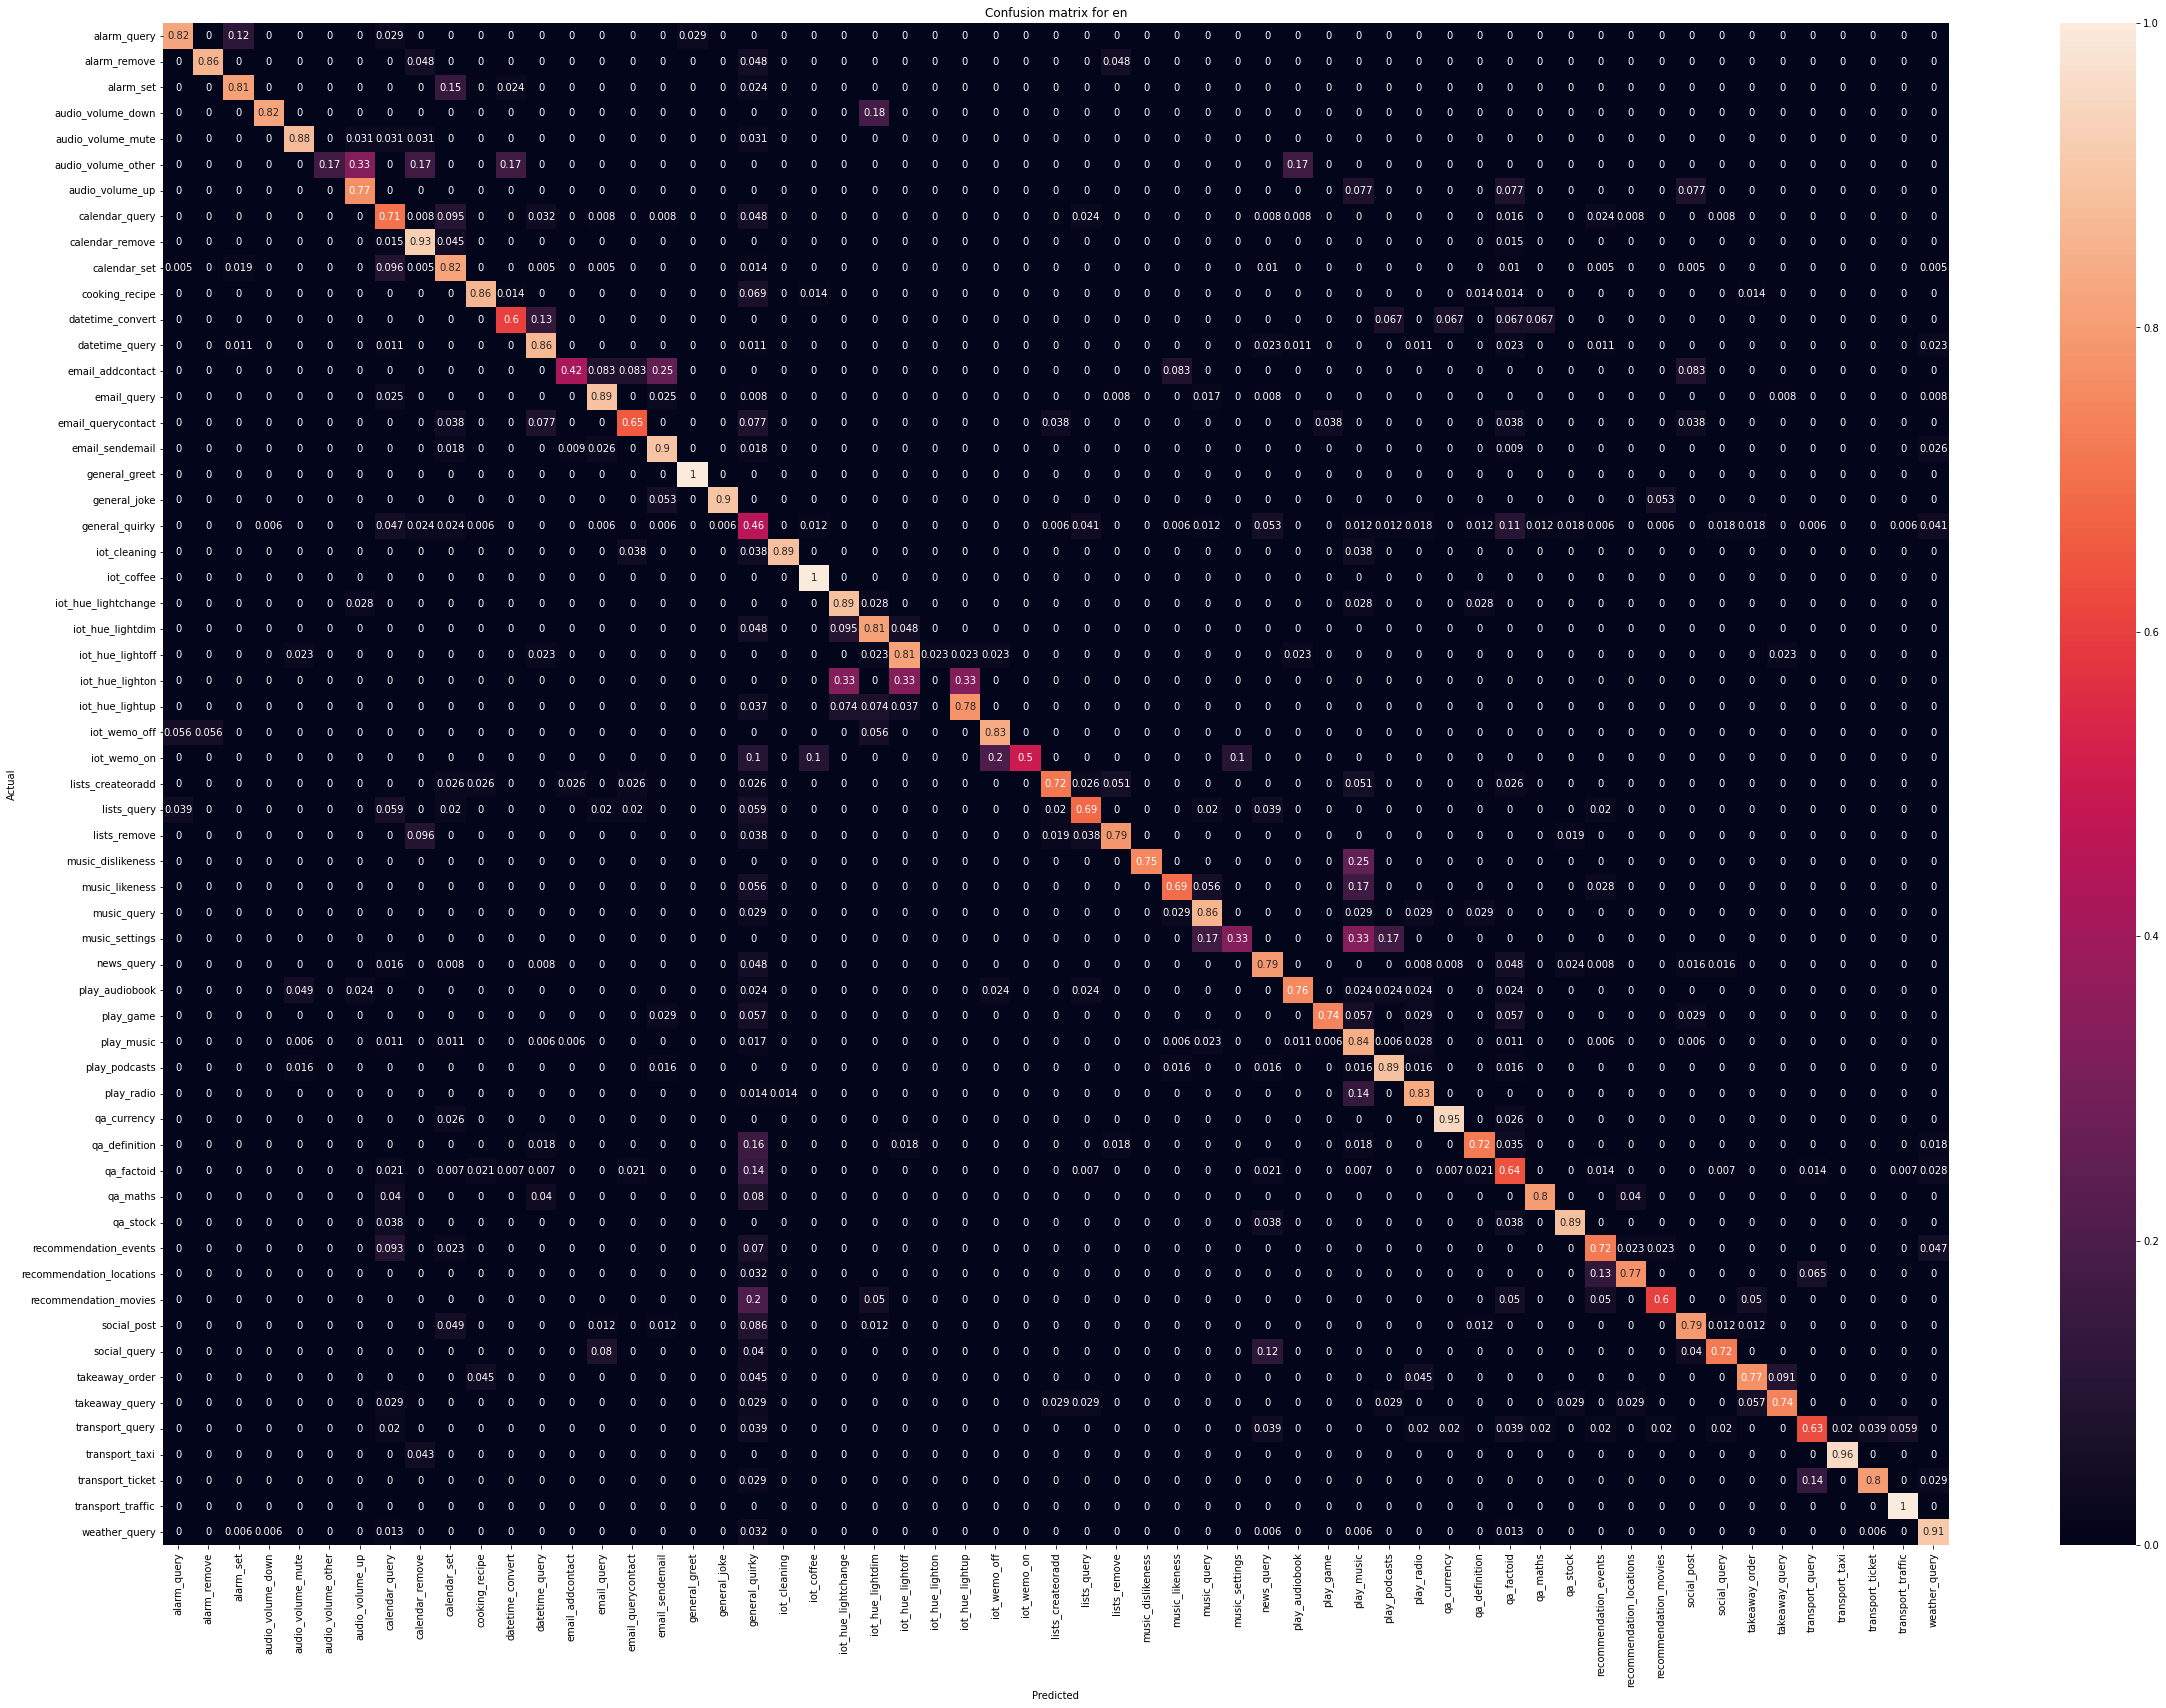

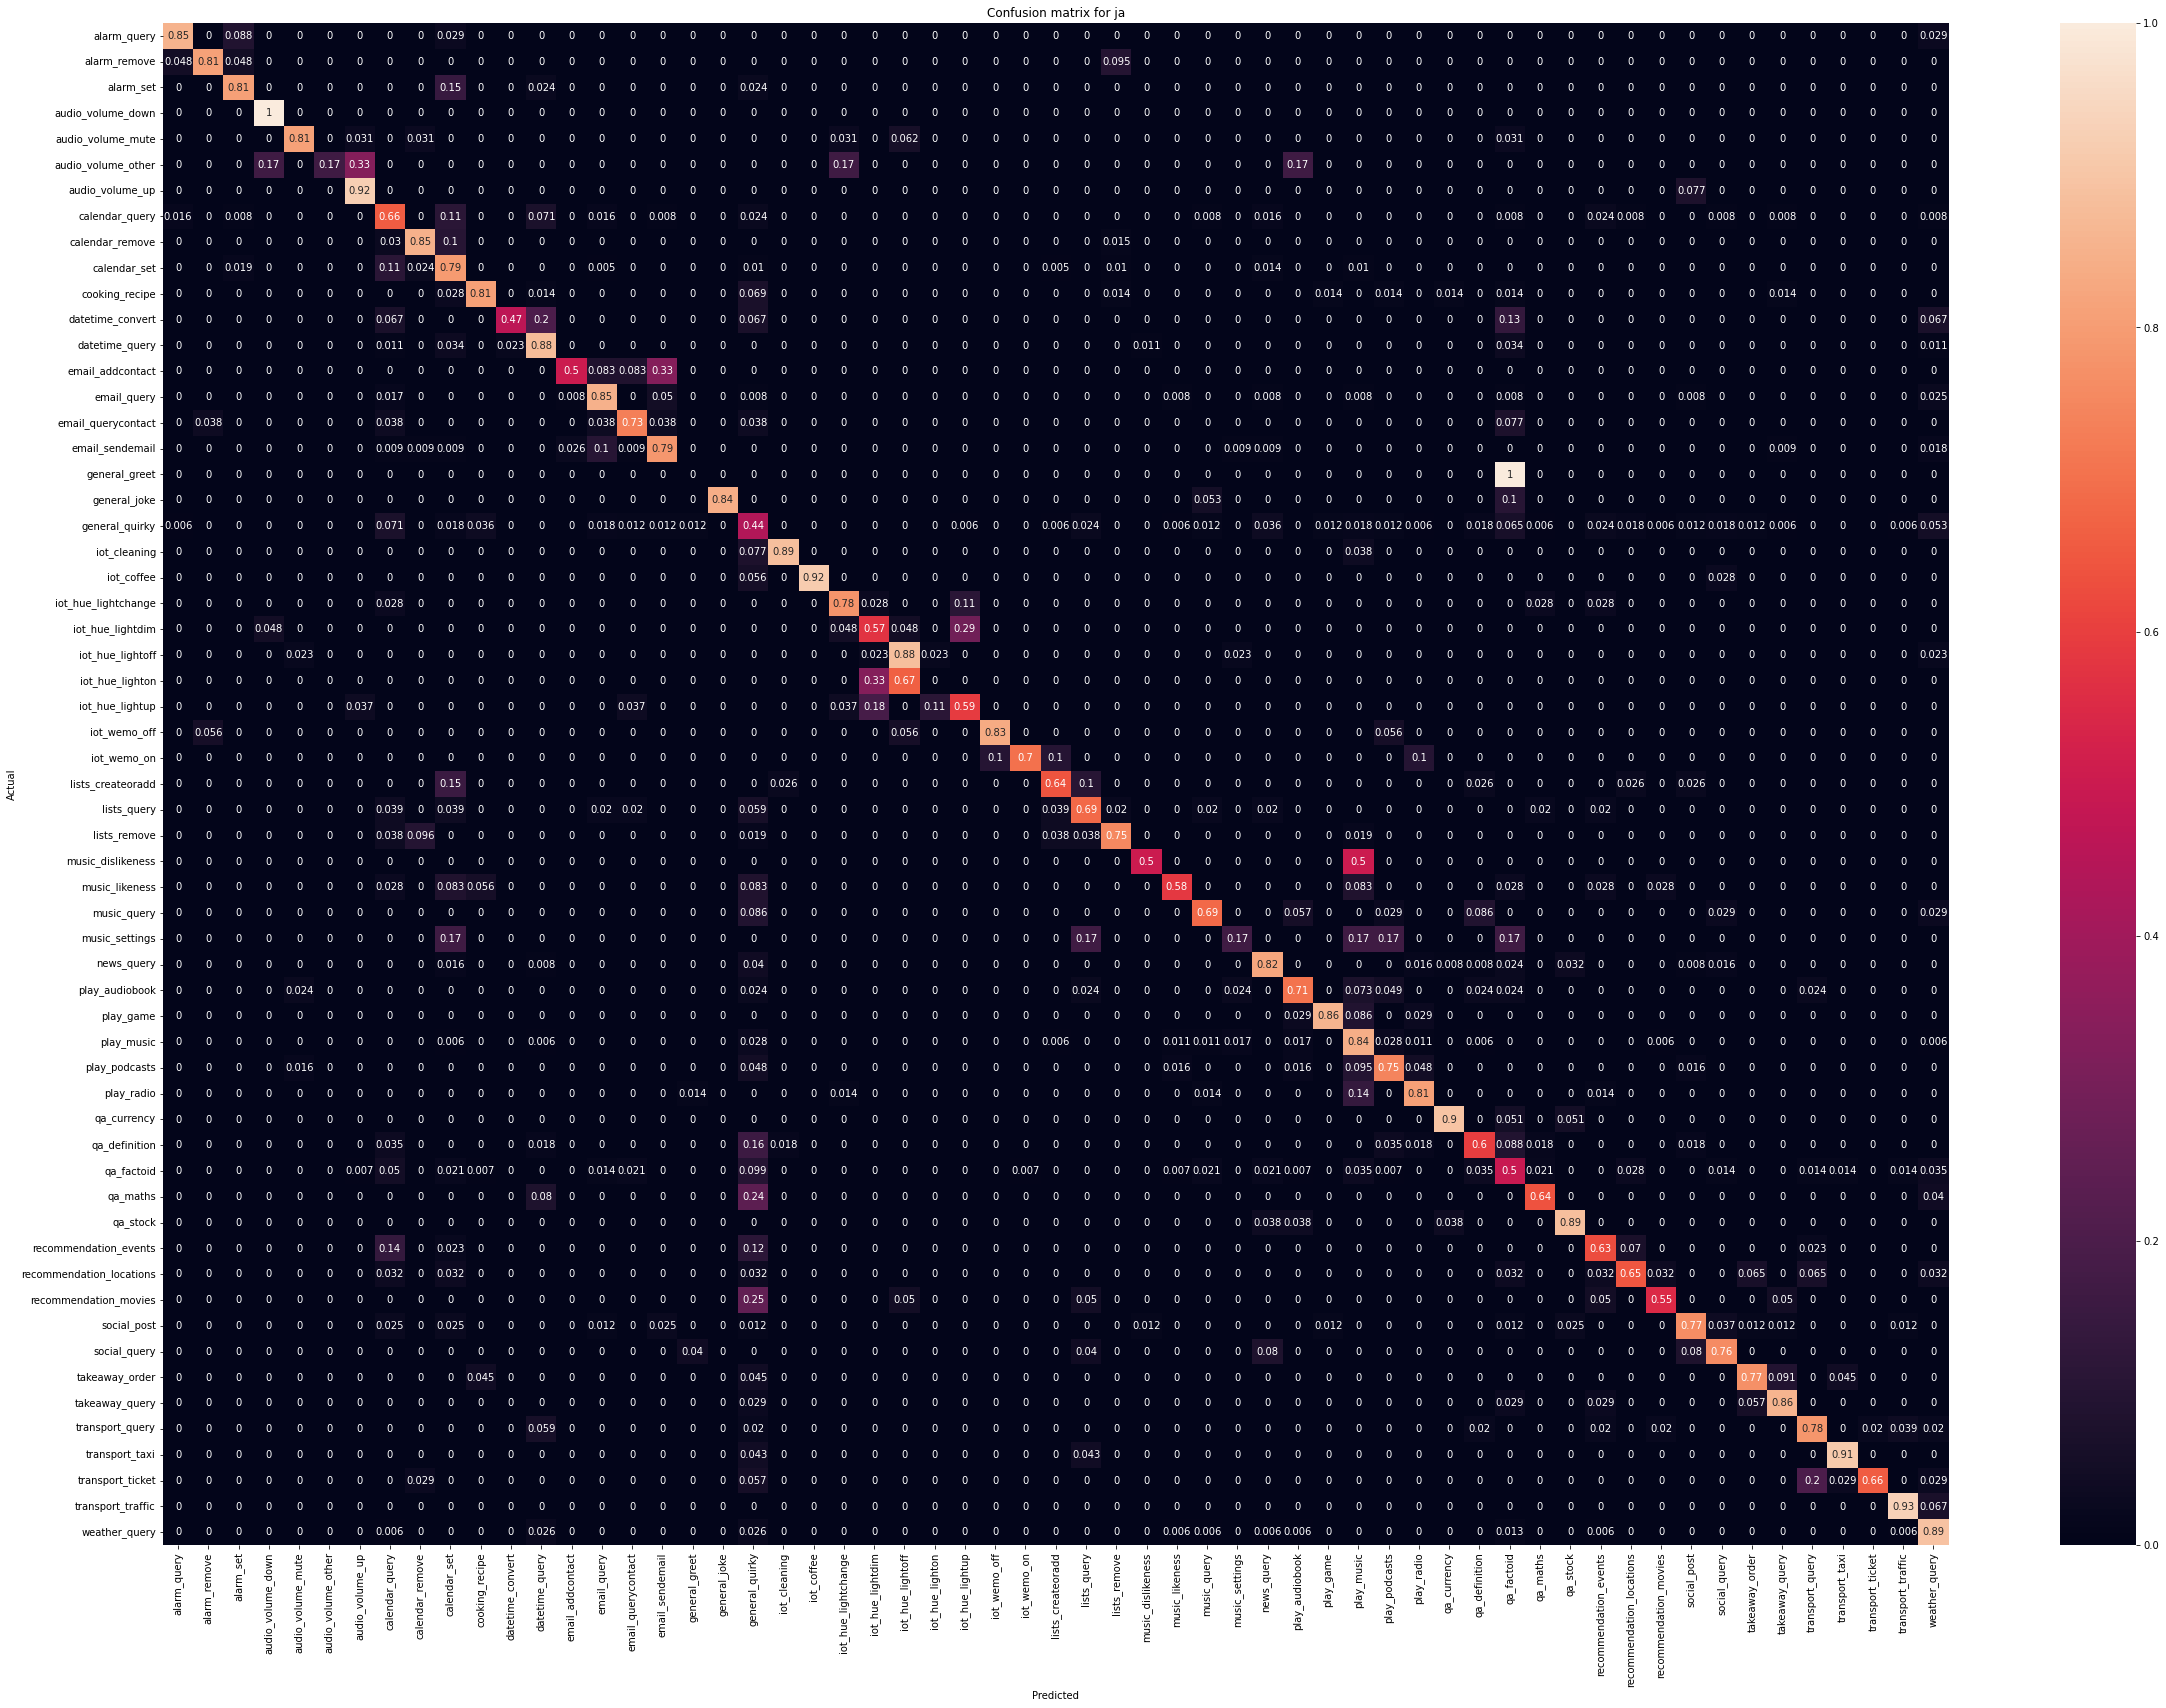

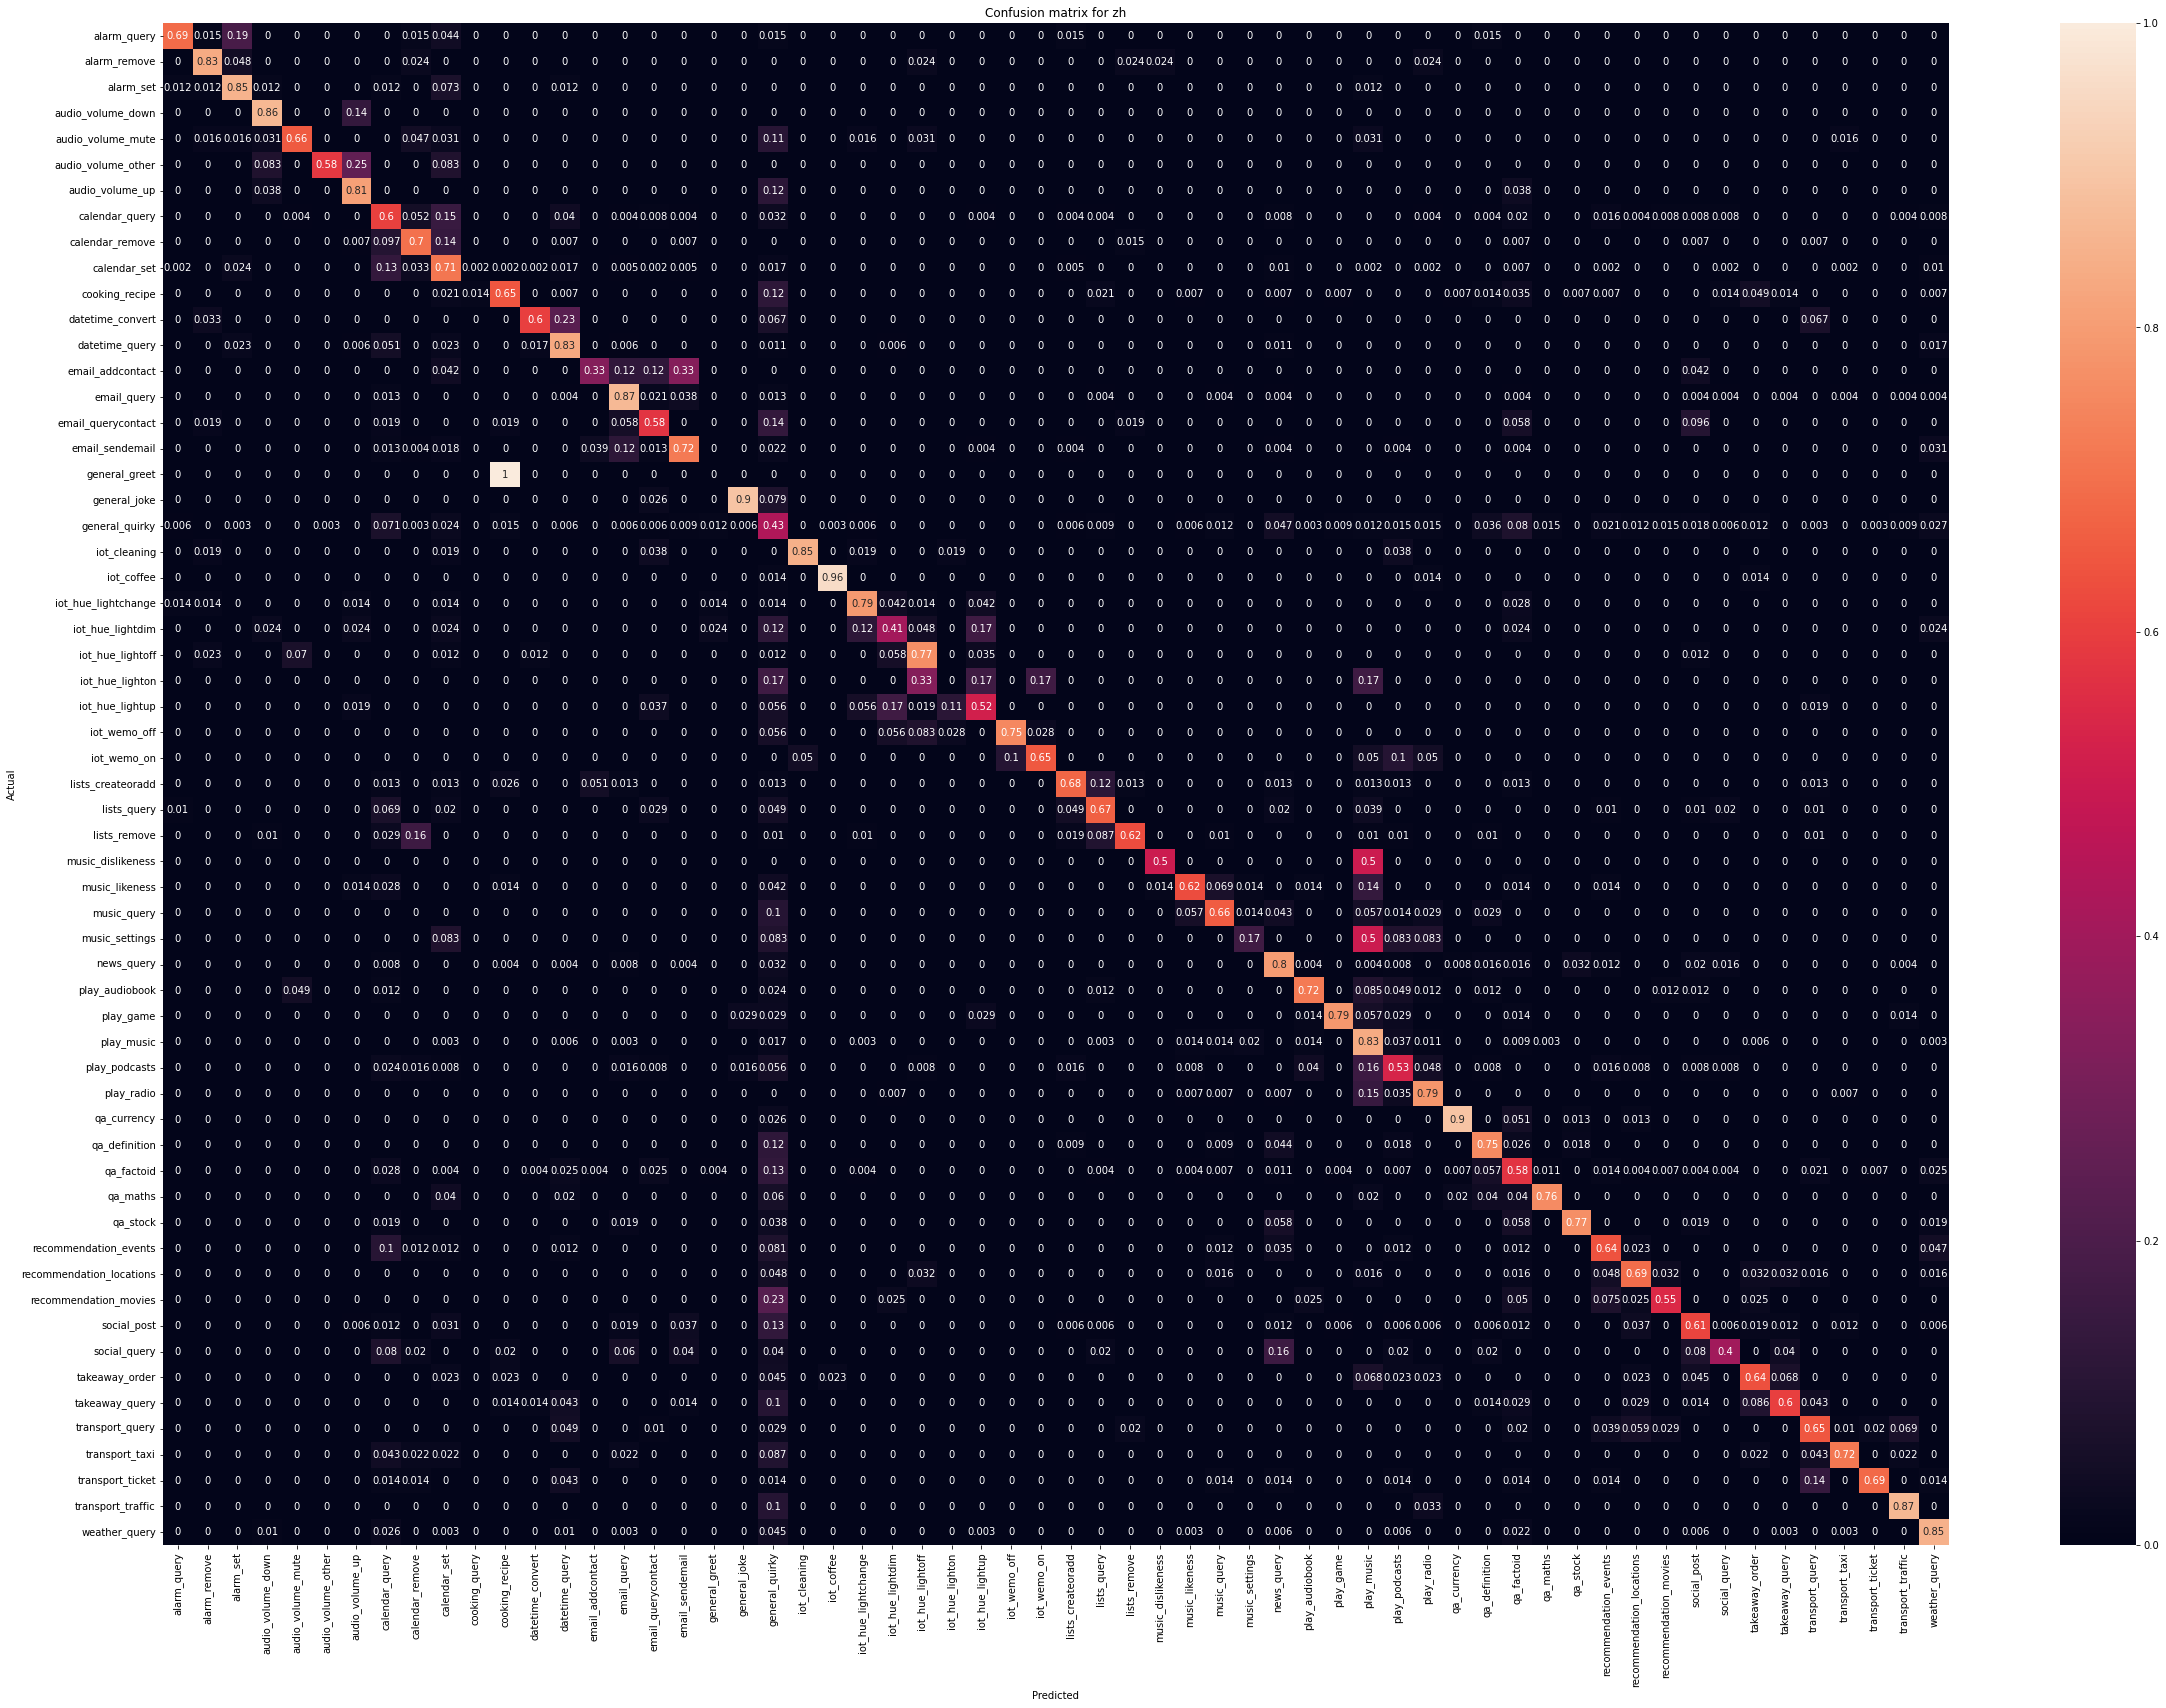

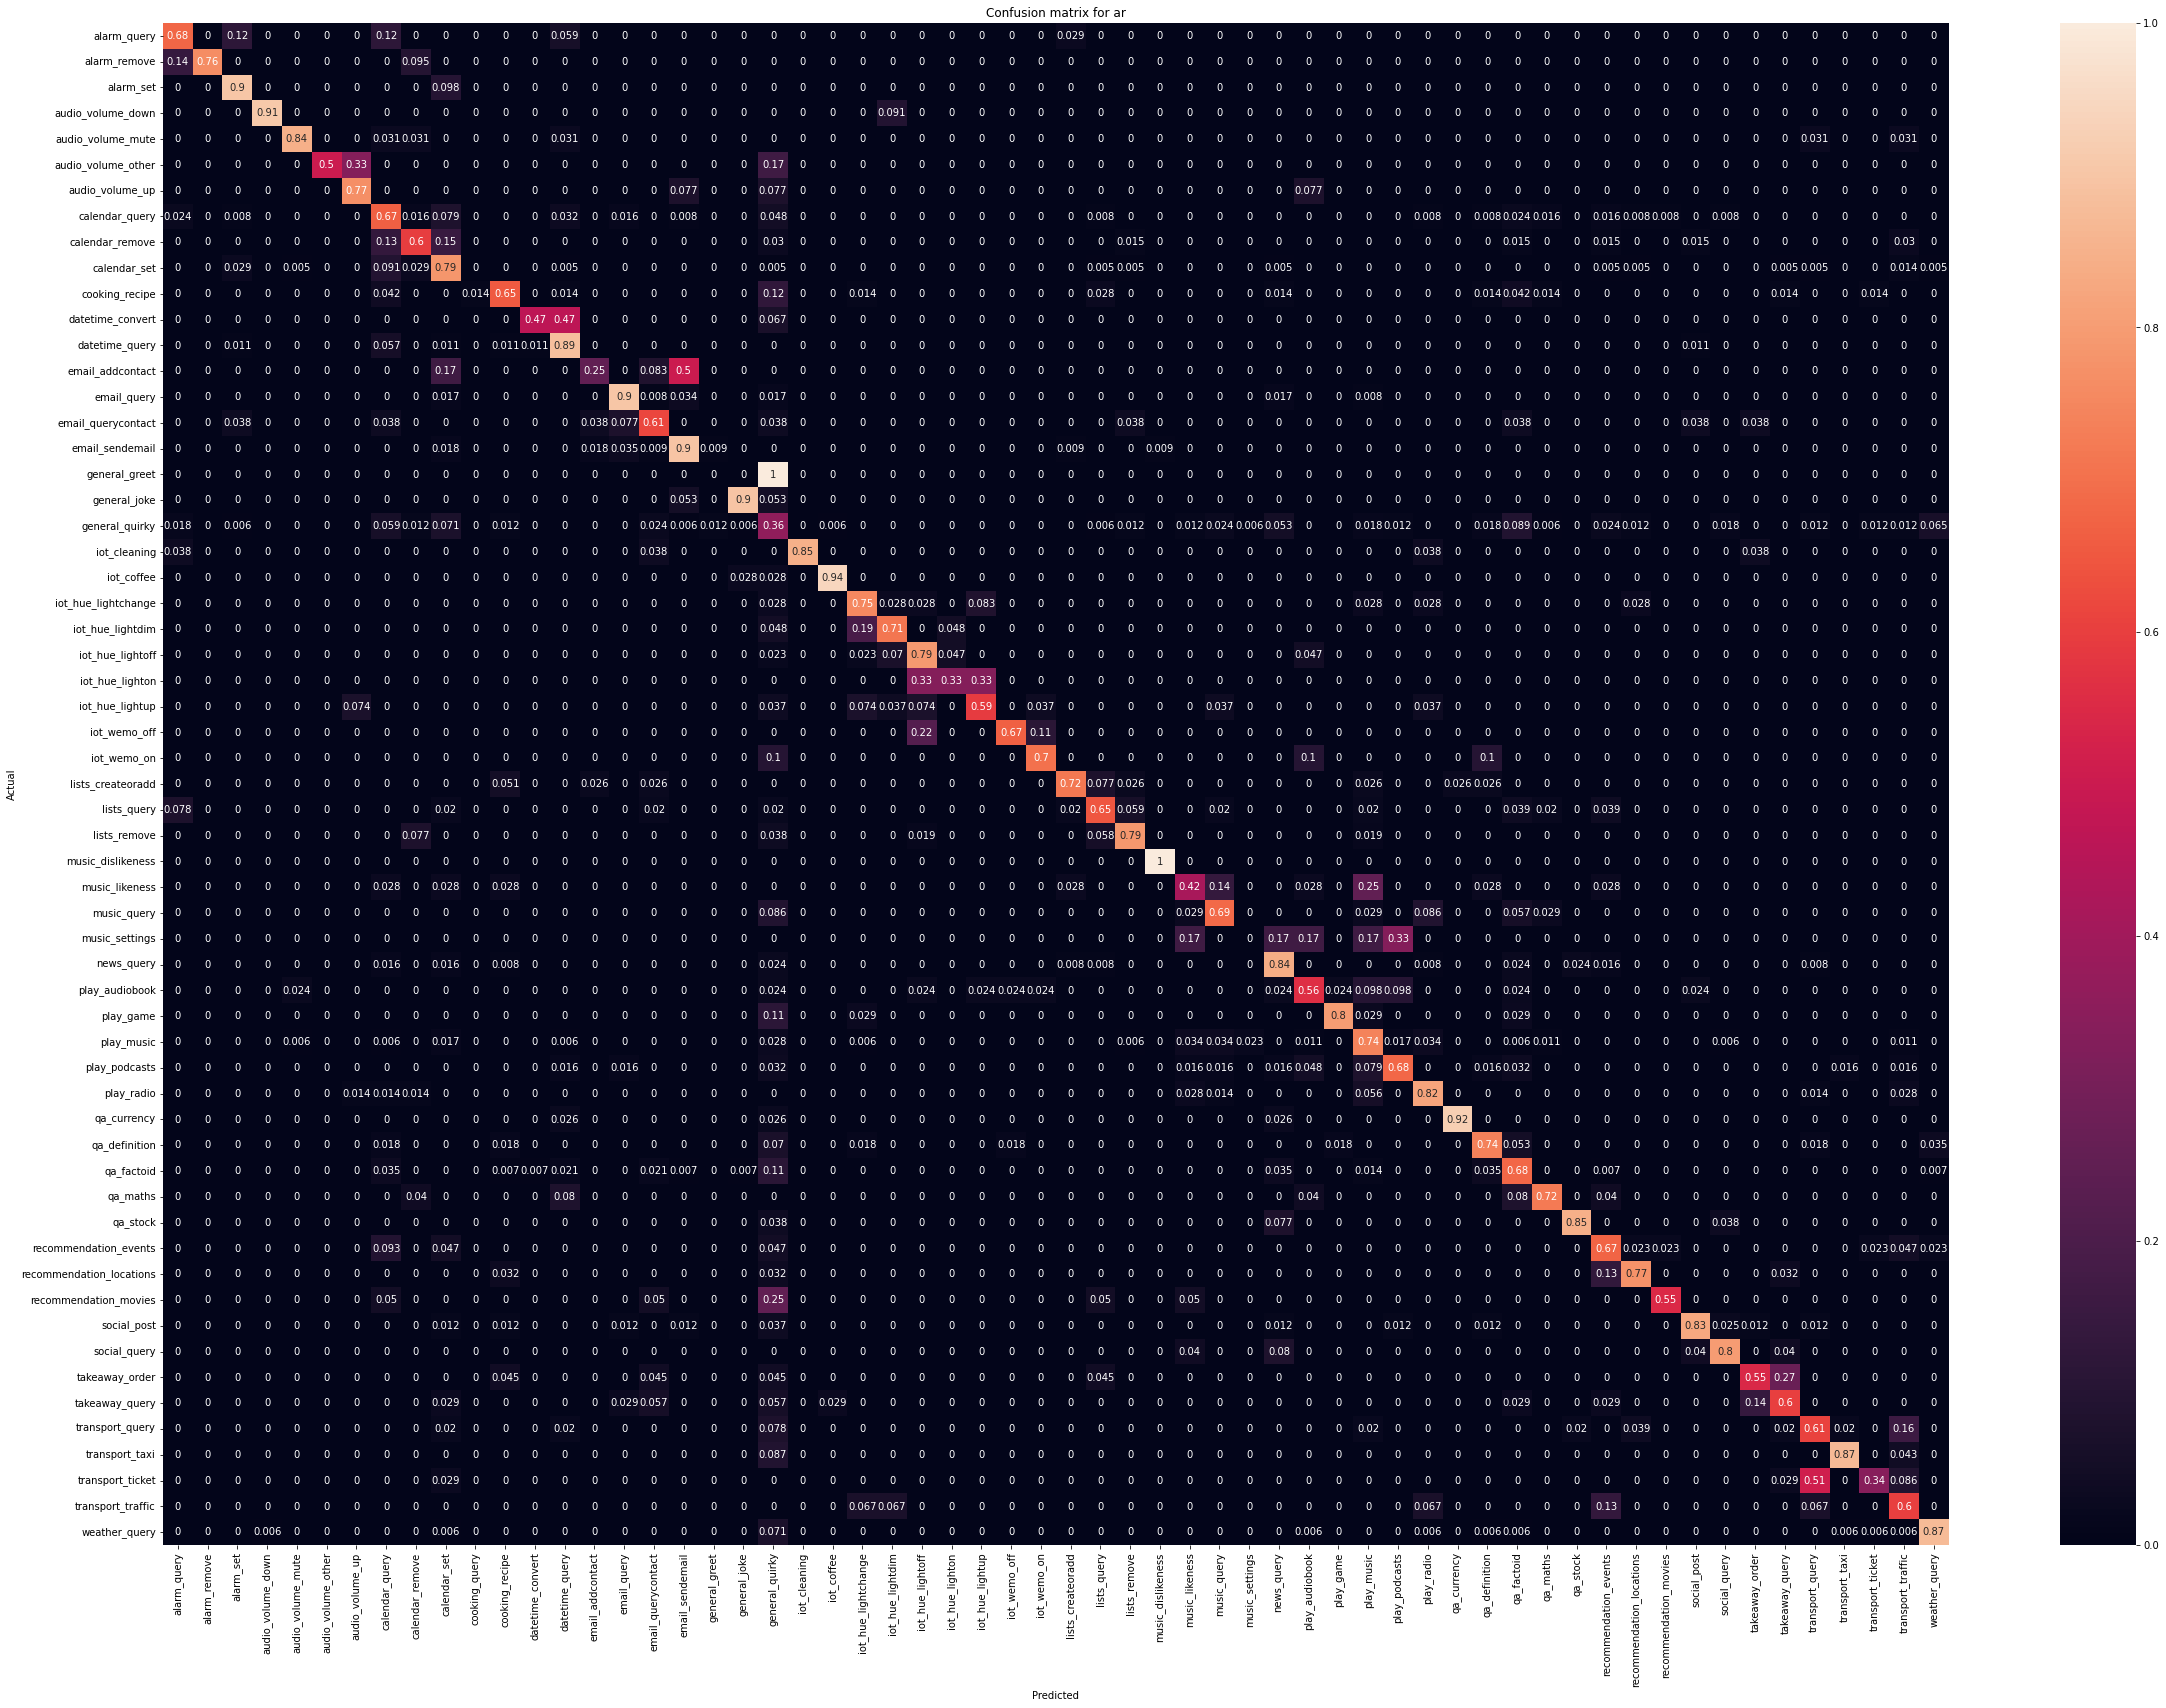

In [15]:
evaluate_model(xgboost, testing_inputs, testing_classes, encoder, indices)

In [16]:
lr = LogisticRegression(penalty='l2', solver='saga', max_iter=100, C=0.5, class_weight='balanced')

lr.fit(training_inputs, training_classes)

C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.5, class_weight='balanced', solver='saga')

Evaluation metrics for LogisticRegression
LogisticRegression's default score metric: 0.7597610664978837
Classification report
              precision    recall  f1-score   support

           0     0.8510    0.8235    0.8370      1734
           1     0.8106    0.8273    0.8189      1071
           2     0.7828    0.8446    0.8125      2091
           3     0.7073    0.8788    0.7838       561
           4     0.6539    0.7837    0.7129      1632
           5     0.6350    0.6765    0.6551       306
           6     0.6013    0.6757    0.6364       663
           7     0.6587    0.6215    0.6396      6426
           8     0.8159    0.8704    0.8423      3417
           9     0.8909    0.7734    0.8280     10659
          10     0.0000    1.0000    0.0000         0
          11     0.7828    0.7225    0.7515      3672
          12     0.6390    0.7033    0.6696       765
          13     0.7738    0.8385    0.8048      4488
          14     0.5180    0.7516    0.6133       612
         

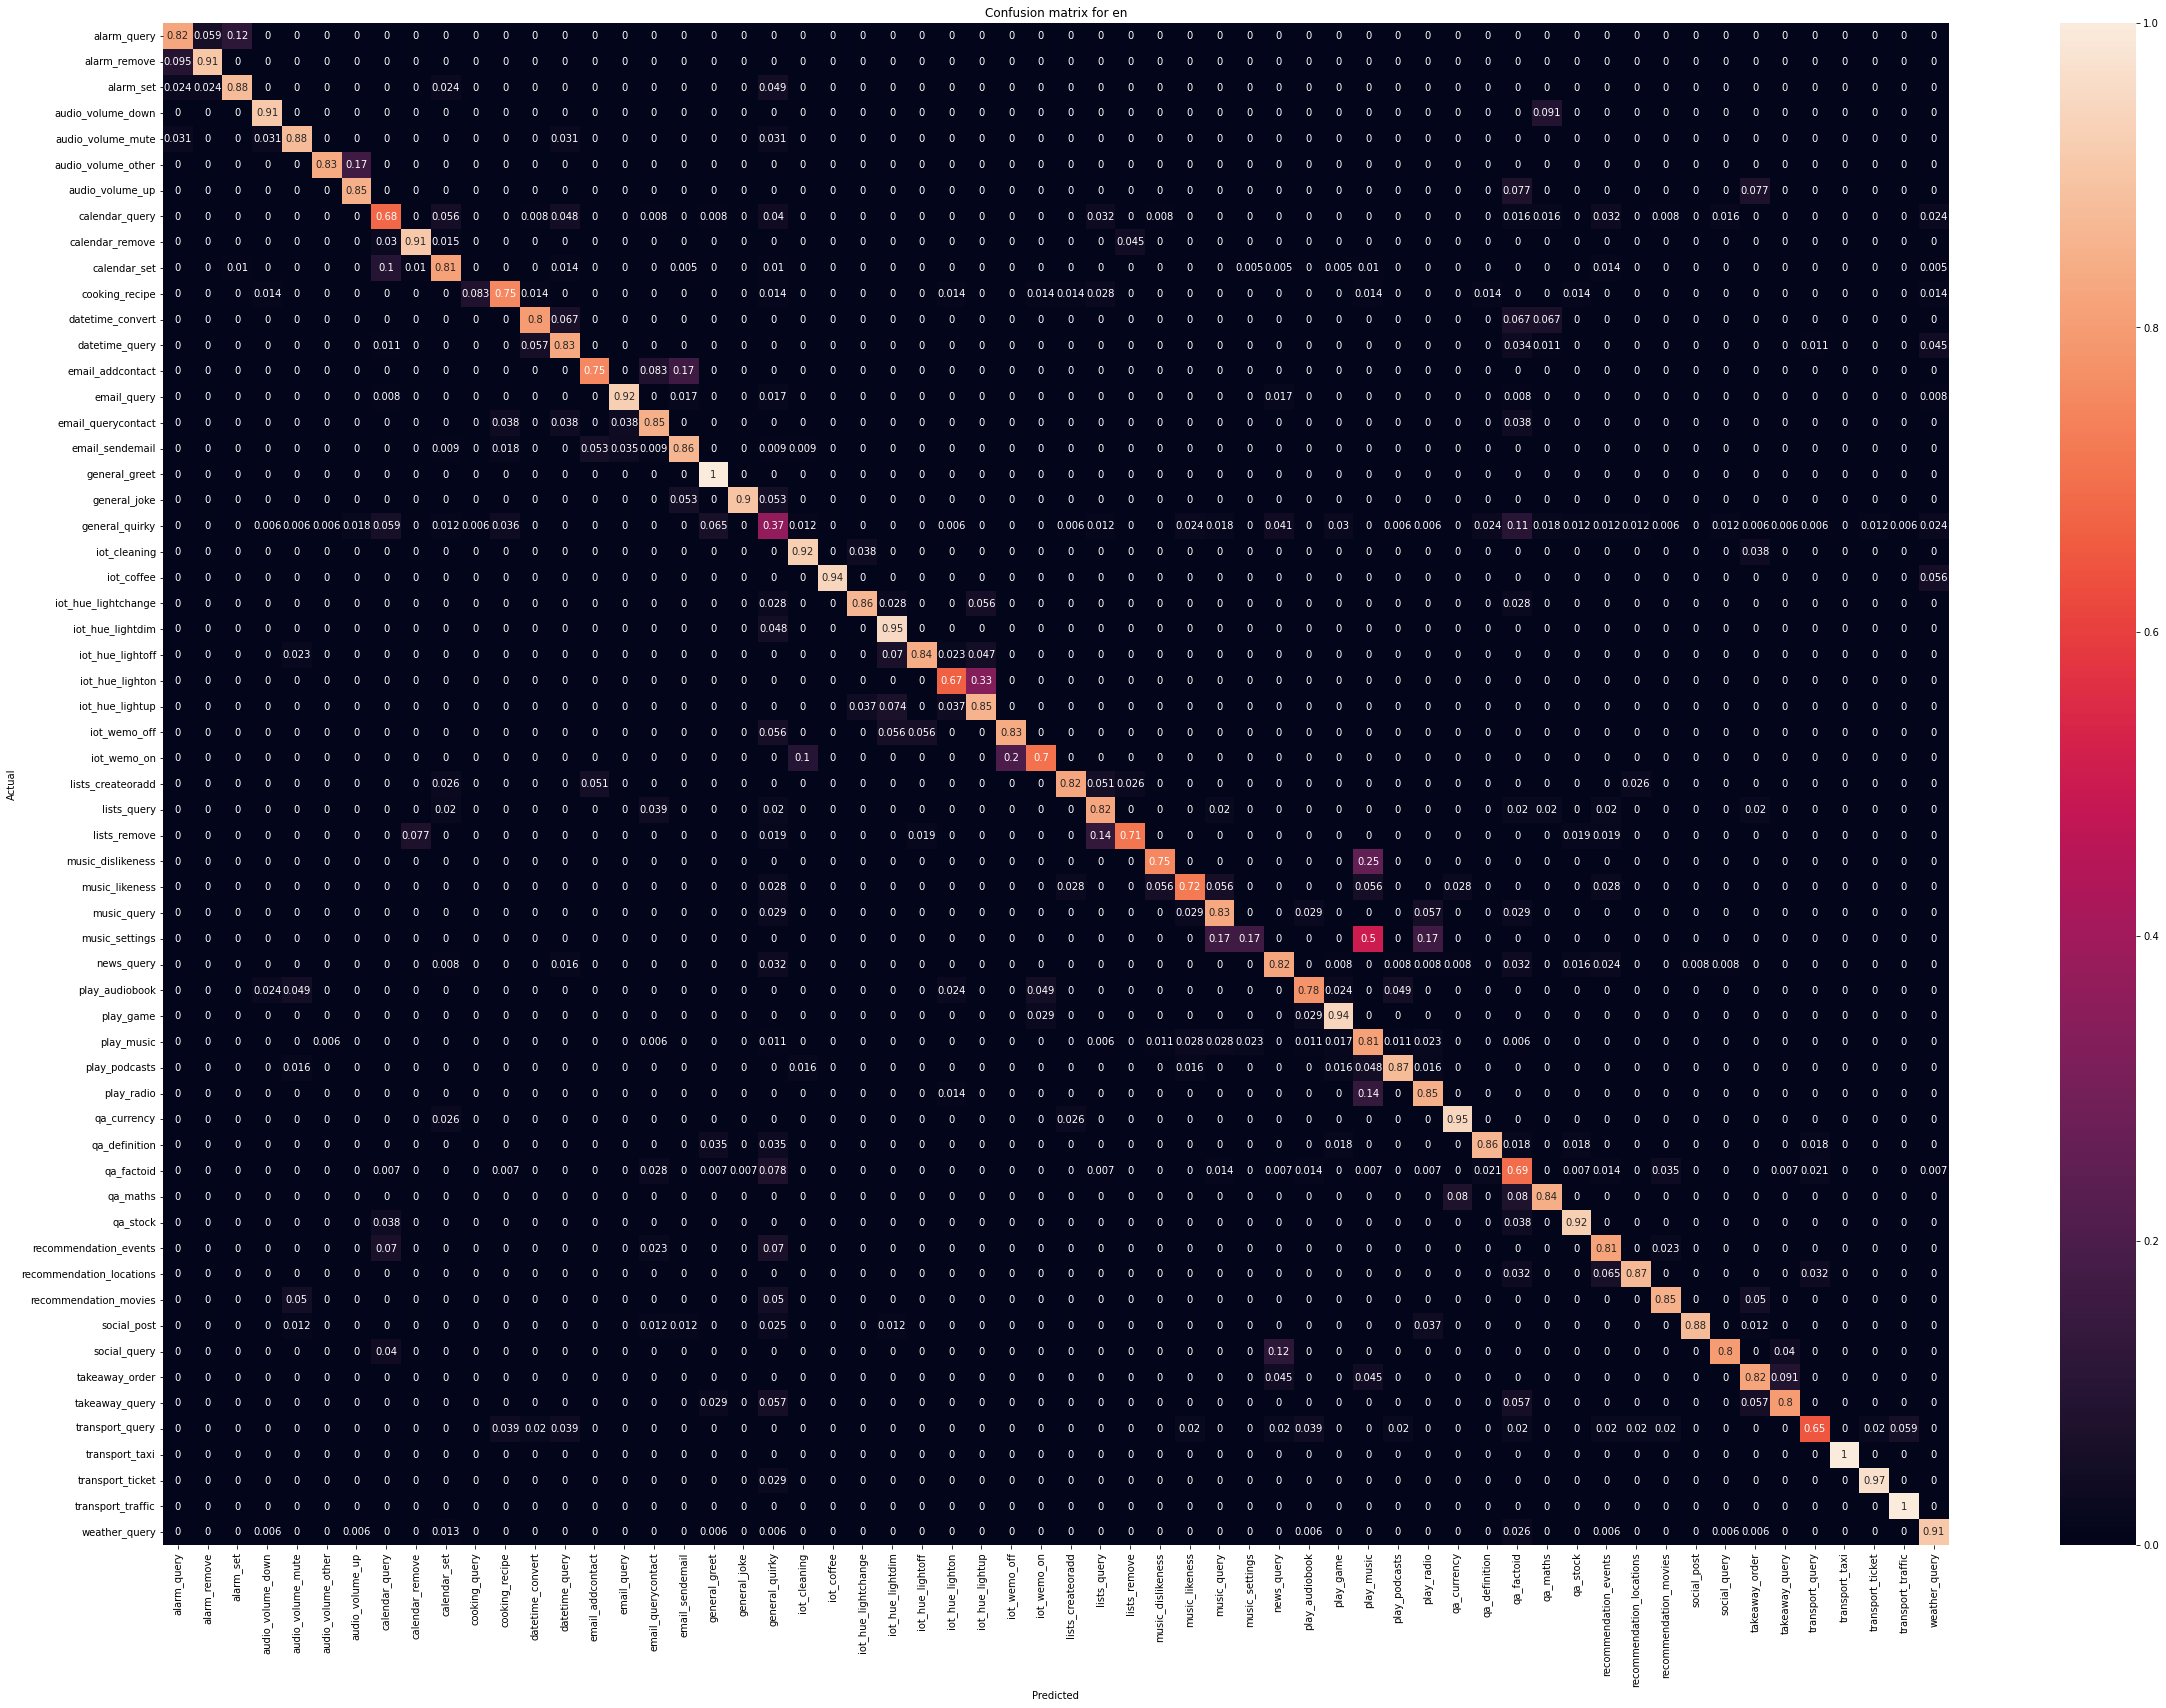

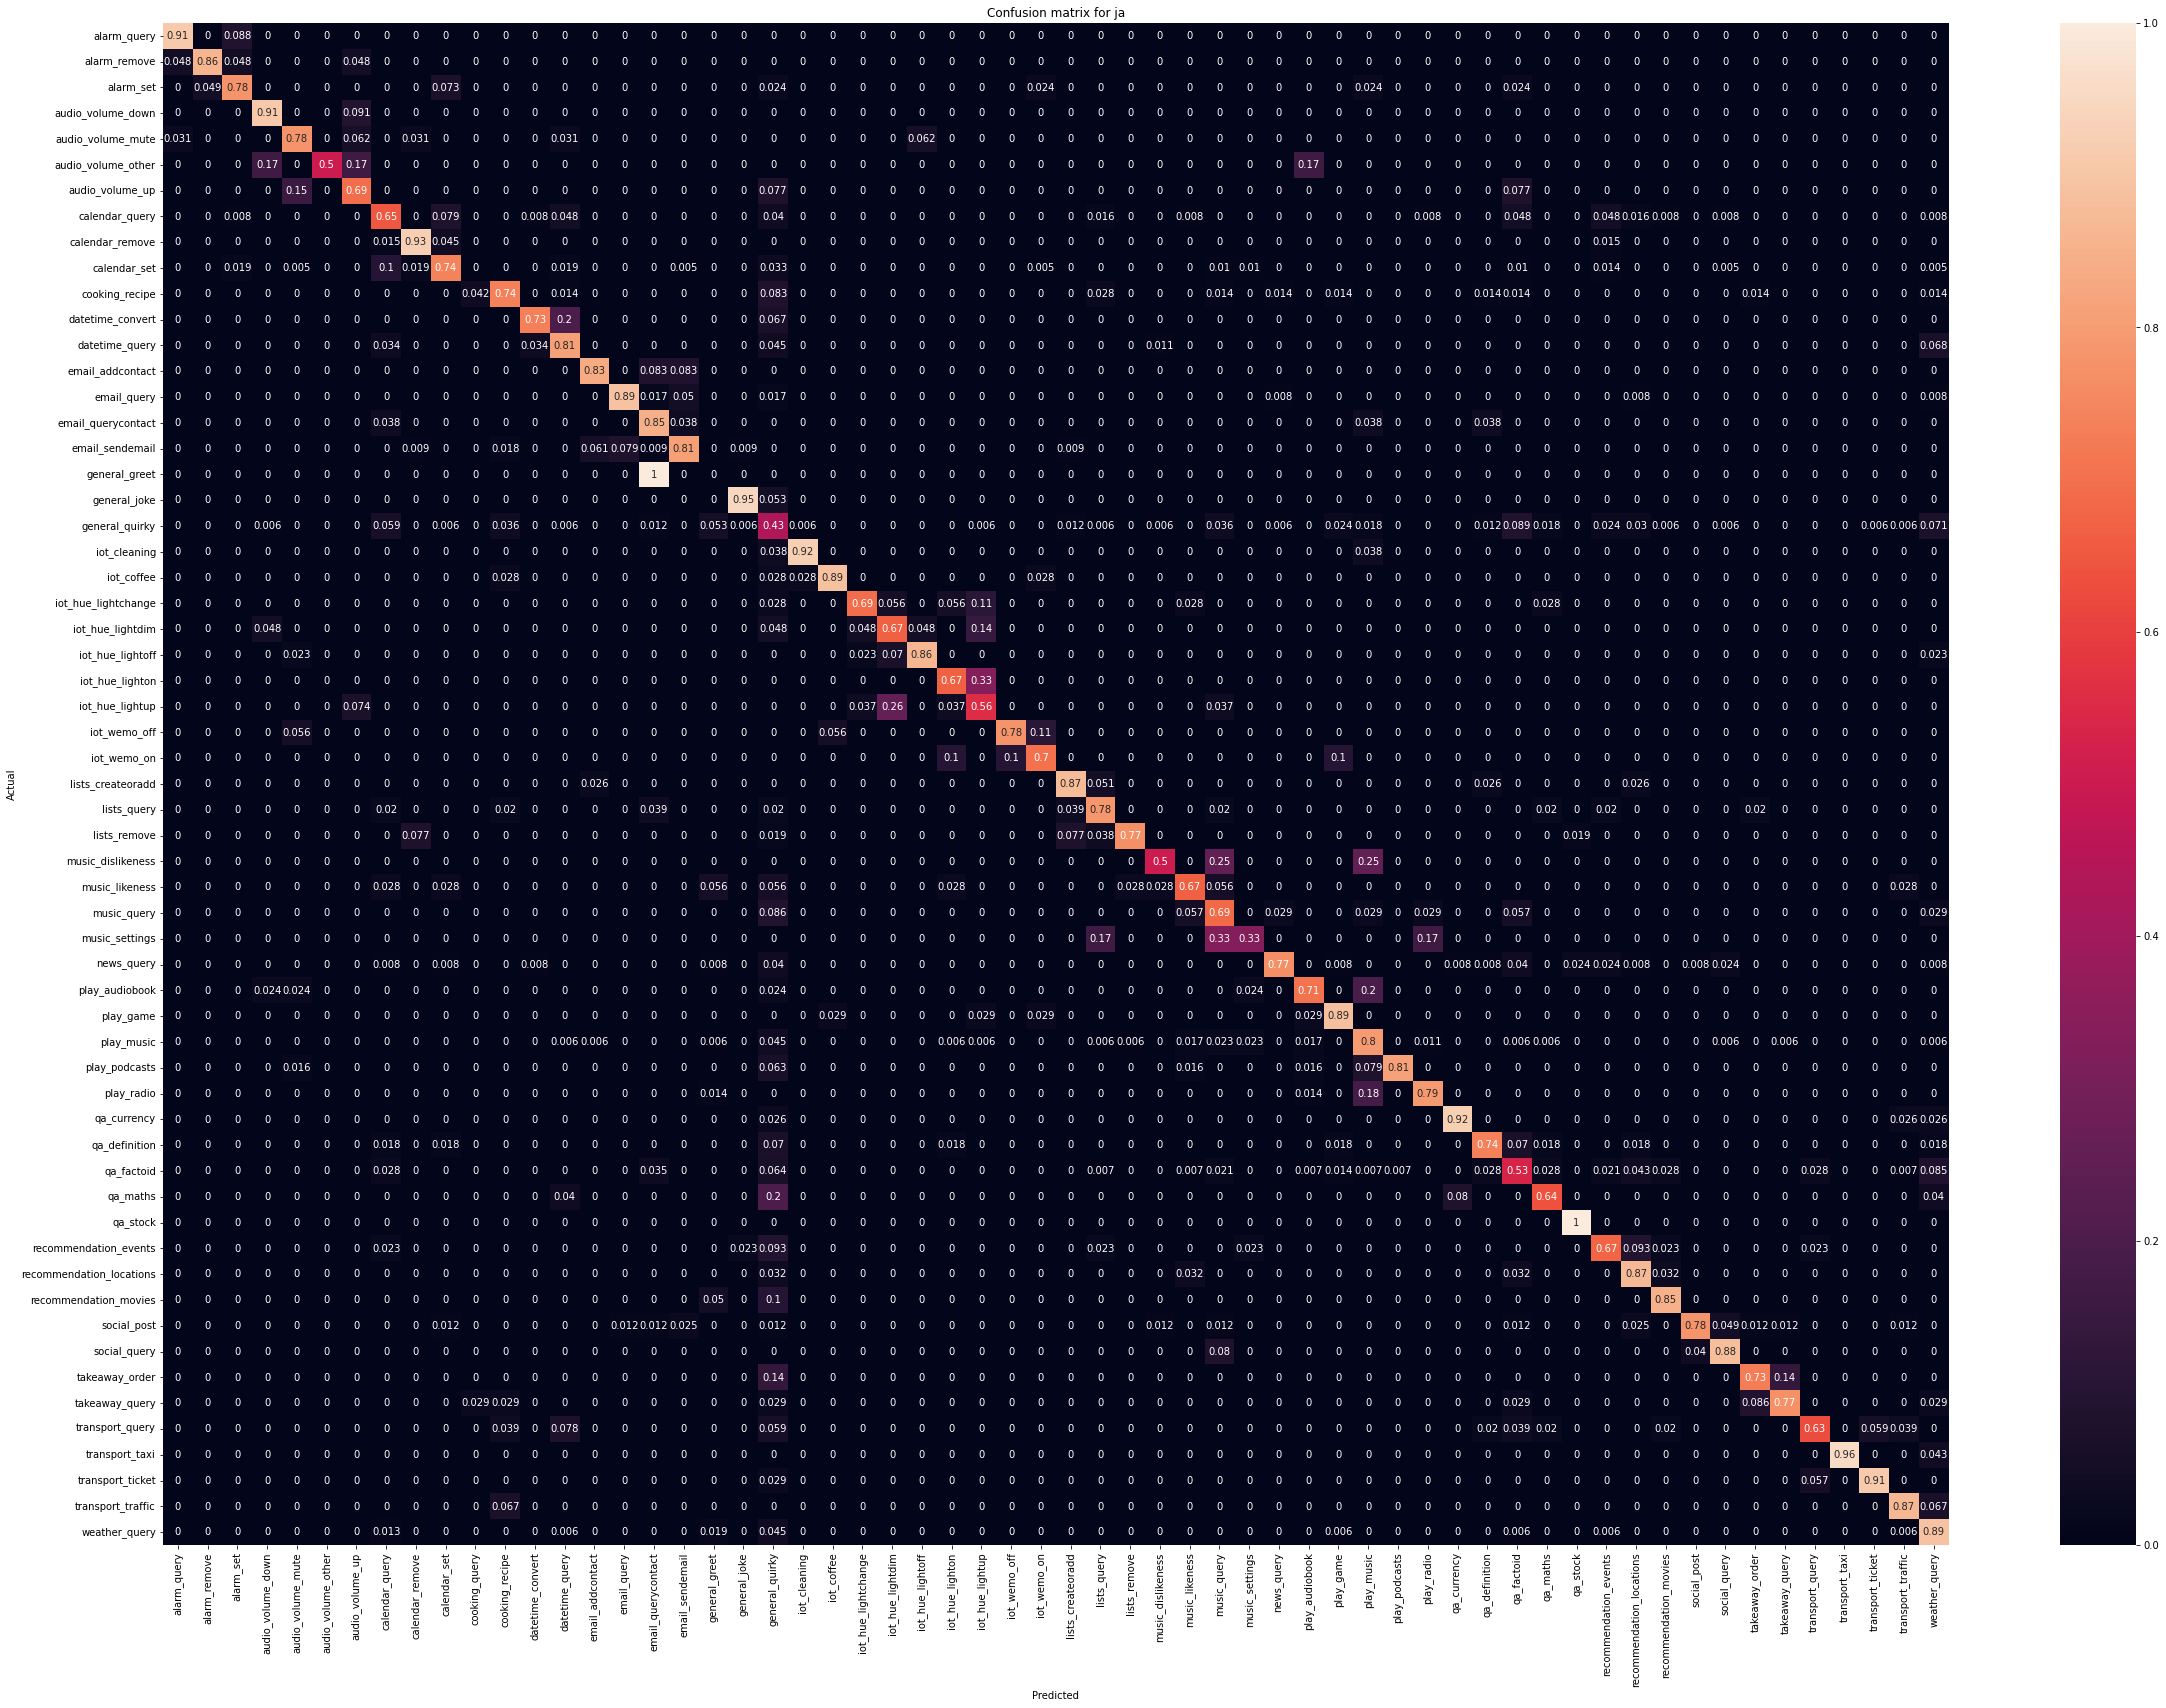

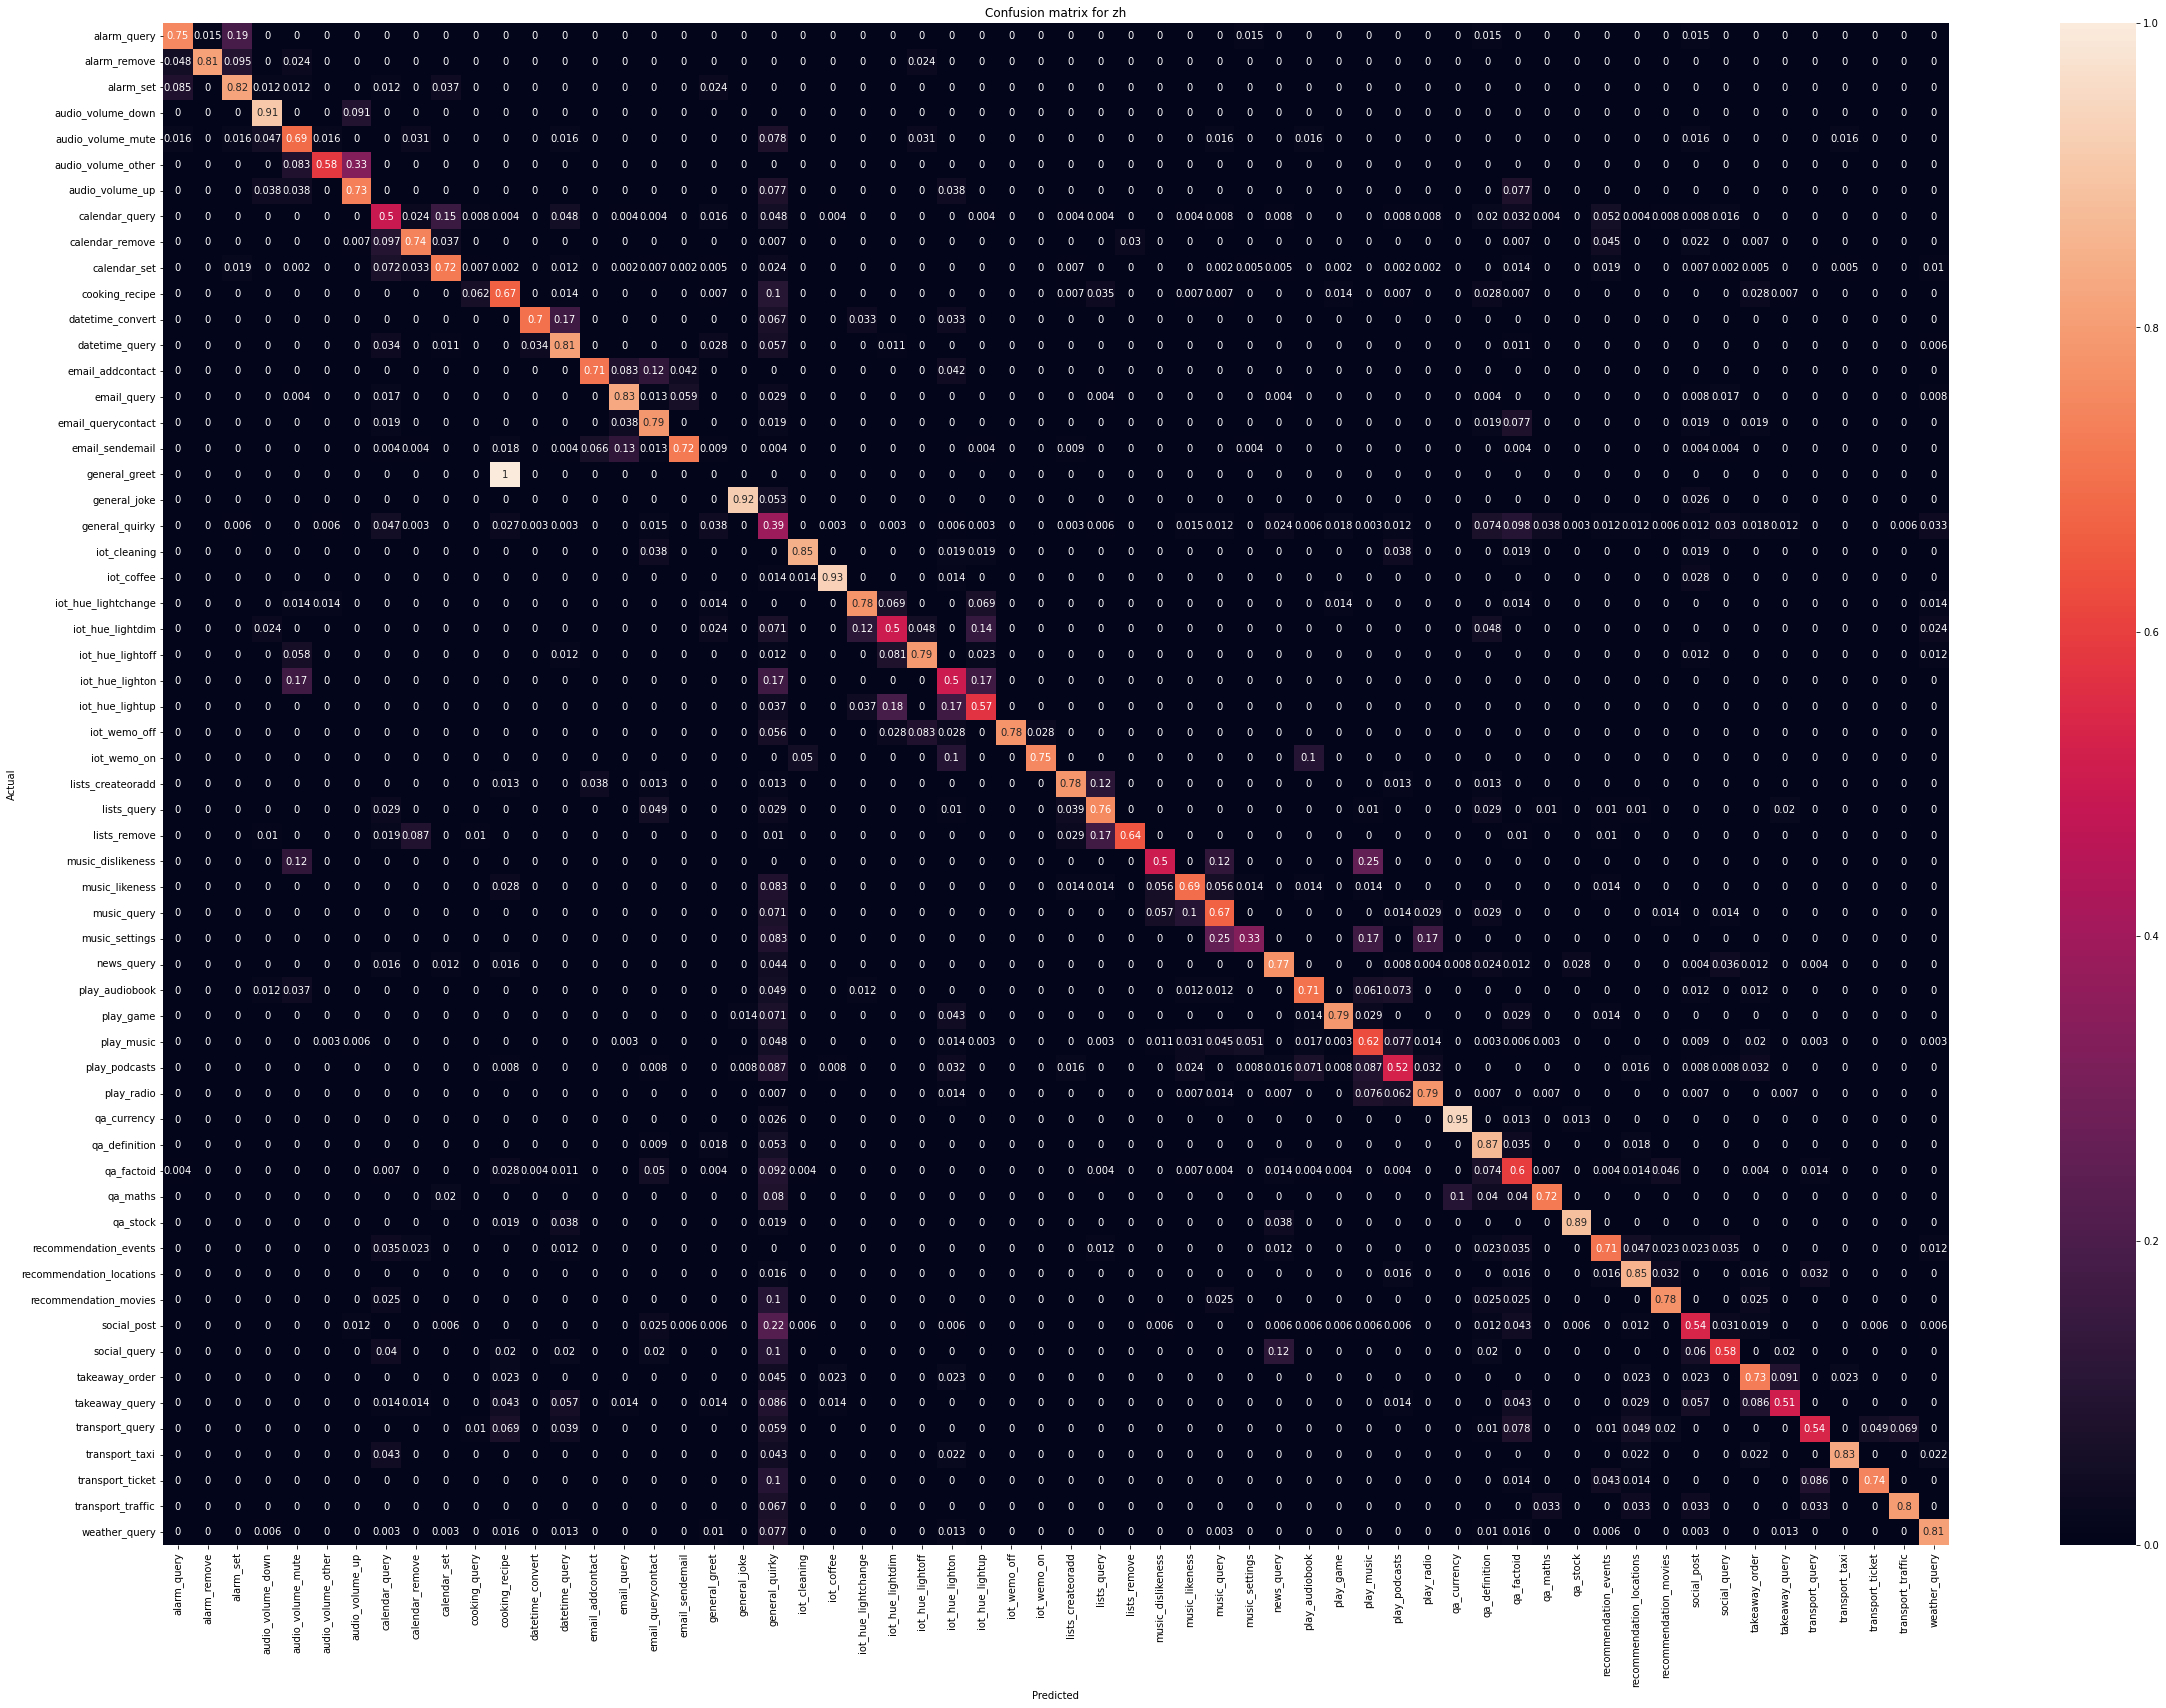

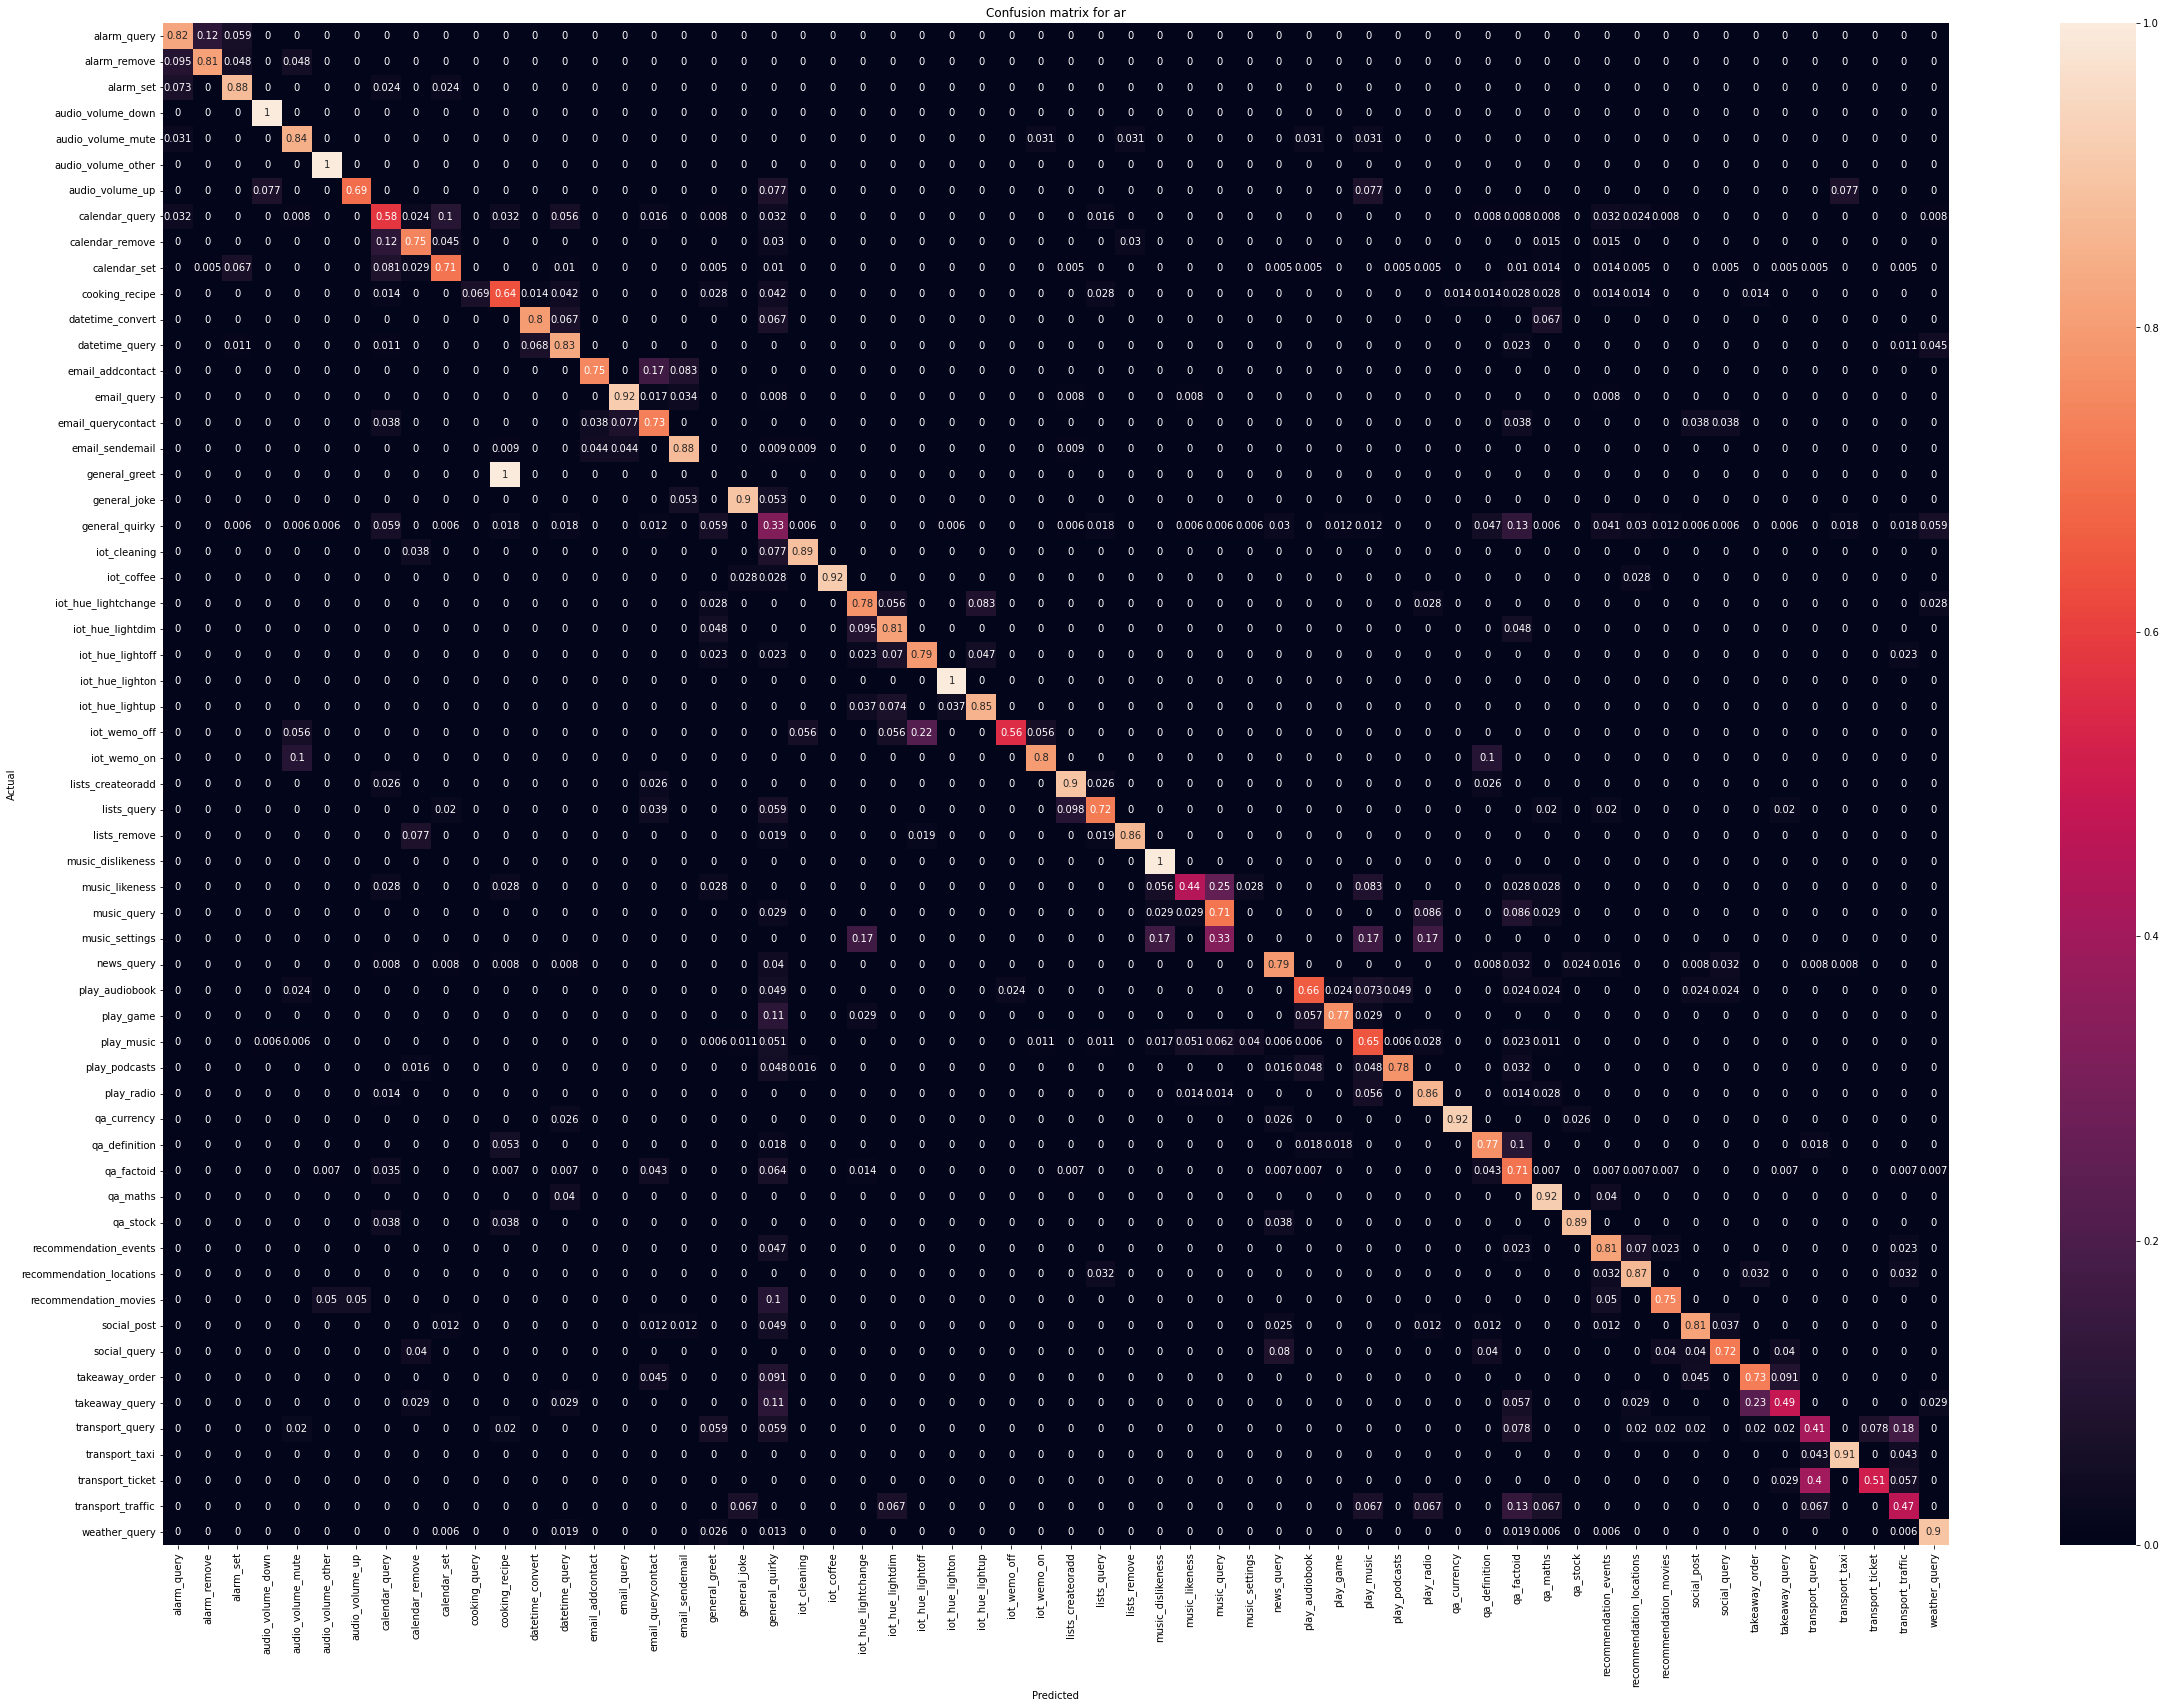

In [17]:
evaluate_model(lr, testing_inputs, testing_classes, encoder, indices)